## Step 1:
load CVS files and nomalize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize, brentq


In [2]:
def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols = {c: str(c).strip().lower().replace(" ", "").replace("_", "") for c in df.columns}
    df = df.rename(columns=cols)

    rename_map = {}
    for c in df.columns:
        if c in ["eventid", "event_id", "id", "event"]:
            rename_map[c] = "eventid"
        elif c in ["classificationscore", "score", "classscore", "cls"]:
            rename_map[c] = "classificationscore"
        elif c in ["energy", "energykev", "e", "energ"]:
            rename_map[c] = "energy"
    df = df.rename(columns=rename_map)

    needed = {"eventid", "classificationscore", "energy"}
    if needed.issubset(df.columns):
        return df[["eventid", "classificationscore", "energy"]].copy()

    raise ValueError(f"Missing {needed - set(df.columns)}. Found columns: {list(df.columns)}")

def load_detector_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # detect "no header" case (column names are numeric strings)
    all_numeric_colnames = True
    for c in df.columns:
        try:
            float(str(c))
        except:
            all_numeric_colnames = False
            break

    if all_numeric_colnames and len(df.columns) == 3:
        df = pd.read_csv(path, header=None, names=["eventid", "classificationscore", "energy"])
        return df[["eventid", "classificationscore", "energy"]].copy()

    return _normalize_columns(df)

def preview(df: pd.DataFrame, name: str, n: int = 5) -> None:
    # enforce types (nice formatting + fewer surprises later)
    out = df.copy()
    out["eventid"] = pd.to_numeric(out["eventid"], errors="coerce").astype("Int64")
    out["classificationscore"] = pd.to_numeric(out["classificationscore"], errors="coerce")
    out["energy"] = pd.to_numeric(out["energy"], errors="coerce")

    # quick stats
    missing = out.isna().sum()
    print(f"\n=== {name} ===")
    print(f"shape: {out.shape}")
    print(f"missing: eventid={missing['eventid']}, score={missing['classificationscore']}, energy={missing['energy']}")
    print(
        "score range: "
        f"[{out['classificationscore'].min():.4f}, {out['classificationscore'].max():.4f}]   "
        "energy range: "
        f"[{out['energy'].min():.2f}, {out['energy'].max():.2f}] keV"
    )

    # show head as a clean table with fixed rounding
    display(out.head(n).style.format({
        "eventid": "{:d}",
        "classificationscore": "{:.4f}",
        "energy": "{:.2f}"
    }))

In [3]:
# ---- Load ----
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)
pd.set_option("display.precision", 4)

DATA_DIR = "data" 
PATH_A = f"{DATA_DIR}/DetectorA.csv"
PATH_B = f"{DATA_DIR}/DetectorB.csv"
PATH_C = f"{DATA_DIR}/DetectorC.csv"
PATH_T = f"{DATA_DIR}/DetectorTarget.csv"

A = load_detector_csv(PATH_A)
B = load_detector_csv(PATH_B)
C = load_detector_csv(PATH_C)
T = load_detector_csv(PATH_T)

preview(A, "Detector A")
preview(B, "Detector B")
preview(C, "Detector C")
preview(T, "Detector Target")


=== Detector A ===
shape: (40000, 3)
missing: eventid=0, score=0, energy=0
score range: [0.0000, 0.9720]   energy range: [1000.02, 3475.61] keV


,eventid,classificationscore,energy
0,734628,0.4400,2123.51
1,229218,0.1790,1017.99
2,428880,0.0280,1862.96
3,1990,0.0800,1619.84
4,55401,0.0650,2611.72



=== Detector B ===
shape: (40000, 3)
missing: eventid=0, score=0, energy=0
score range: [0.0000, 0.9630]   energy range: [1000.01, 4998.51] keV


,eventid,classificationscore,energy
0,931205,0.0730,2223.60
1,300504,0.2140,1593.26
2,156507,0.4680,2203.01
3,454926,0.0270,2491.59
4,875363,0.2480,2498.08



=== Detector C ===
shape: (40000, 3)
missing: eventid=0, score=0, energy=0
score range: [0.0000, 0.9710]   energy range: [1000.11, 3351.51] keV


,eventid,classificationscore,energy
0,43866,0.0250,2613.88
1,689667,0.2570,1166.90
2,383283,0.0020,2129.72
3,644063,0.0580,2386.96
4,759105,0.5090,1044.46



=== Detector Target ===
shape: (4902, 3)
missing: eventid=0, score=0, energy=0
score range: [0.0000, 0.9630]   energy range: [1000.01, 4177.60] keV


,eventid,classificationscore,energy
0,2483681,0.4160,1409.02
1,2678687,0.0100,1839.10
2,2497348,0.0560,2337.49
3,2599649,0.6210,2386.86
4,2616981,0.5120,1954.89


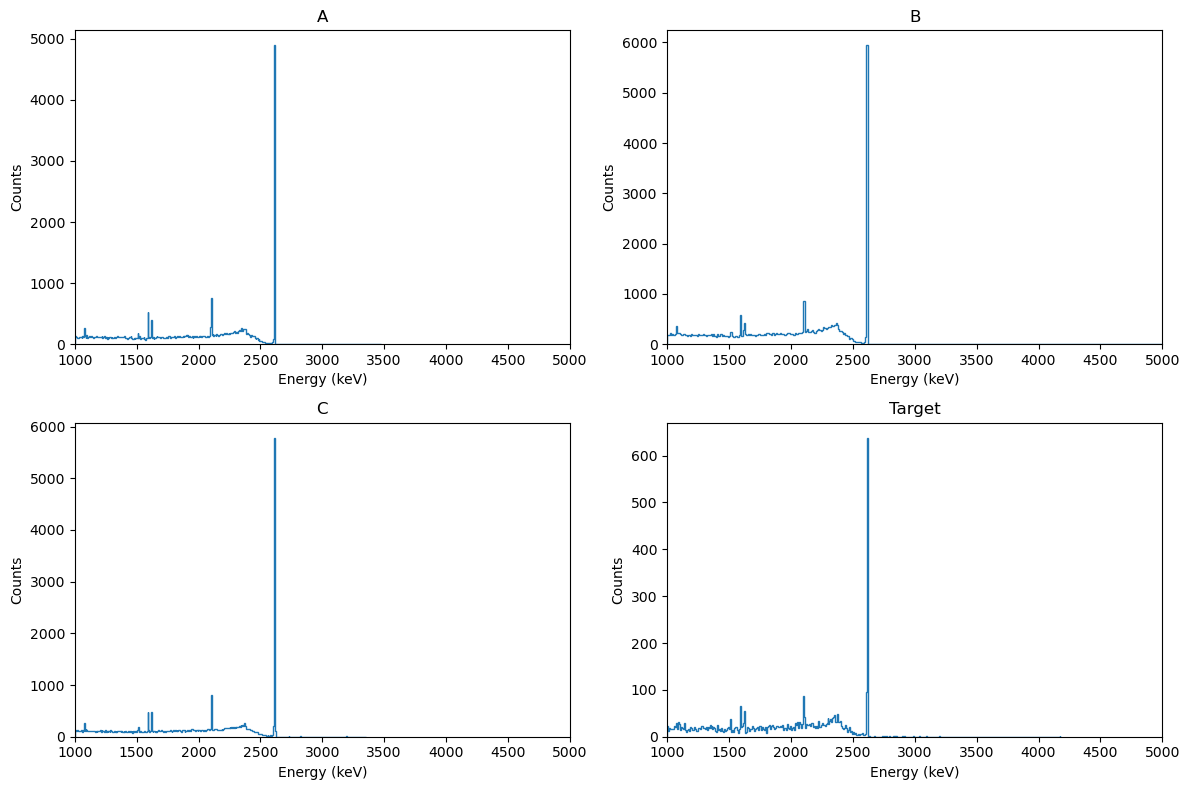

In [4]:
# ============================================
# Make energy spectra (no cut)
# ============================================
def plot_energy_spectra_grid(dfs, labels, bins=400, xlim=(500, 3000)):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)
    axes = axes.ravel()

    for ax, df, lab in zip(axes, dfs, labels):
        ax.hist(df["energy"], bins=bins, histtype="step")
        ax.set_title(lab)
        ax.set_xlim(*xlim)
        ax.set_xlabel("Energy (keV)") 
        ax.set_ylabel("Counts")

    plt.tight_layout()
    plt.show()

plot_energy_spectra_grid([A, B, C, T], ["A", "B", "C", "Target"], bins=400, xlim=(1000, 5000))


## Step 2:
Detector A

In [5]:
def window_mask(energies: np.ndarray, center: float, half_width: float) -> np.ndarray:
    return (energies >= center - half_width) & (energies <= center + half_width)

def get_signal_window_scores(detA: pd.DataFrame, center_keV: float, half_width: float) -> np.ndarray:
    m = window_mask(detA["energy"].values, center_keV, half_width)
    scores = detA.loc[m, "classificationscore"].values
    if len(scores) == 0:
        raise ValueError("No events in signal window. Increase PEAK_HALF_WIDTH or check energy units.")
    return scores

def tpr_from_scores(scores_signal: np.ndarray, thr: float) -> float:
    # fraction passing the cut inside the signal window
    return float((scores_signal >= thr).mean())

def thr_from_target_tpr(scores_signal: np.ndarray, target_tpr: float) -> float:
    # choose thr such that ~target_tpr fraction pass (>= thr)
    # quantile at (1 - target_tpr)
    return float(np.quantile(scores_signal, 1.0 - target_tpr))

thr_min_tpr (TPR≈0.80) = 0.105400
Achieved TPR (A @ 1592.0±3.0 keV) = 0.799235


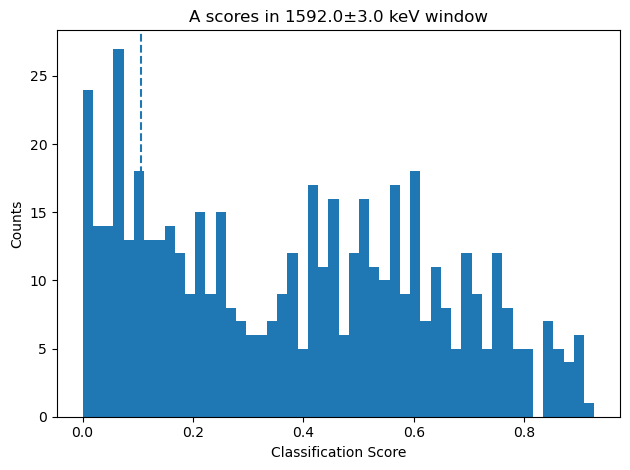

In [6]:
# ============================================================
# Step 1: Choose baseline threshold using A's 1592 keV peak
#         (Constraint: TPR >= 0.80)
# ============================================================
SIGNAL_KEV = 1592.0
PEAK_HALF_WIDTH = 3.0   # keV window half-width
MIN_TPR = 0.80          # constraint: only consider thresholds with TPR >= 0.80

# --- cache scores in 1592±3 keV window (used throughout scan) ---
scores_signal = get_signal_window_scores(A, SIGNAL_KEV, PEAK_HALF_WIDTH)

# baseline: thr_max that still meets TPR >= 0.80 (approximately)
thr_min_tpr = thr_from_target_tpr(scores_signal, MIN_TPR)
achieved_tpr = tpr_from_scores(scores_signal, thr_min_tpr)

print(f"thr_min_tpr (TPR≈{MIN_TPR:.2f}) = {thr_min_tpr:.6f}")
print(f"Achieved TPR (A @ {SIGNAL_KEV}±{PEAK_HALF_WIDTH} keV) = {achieved_tpr:.6f}")

plt.figure()
plt.hist(scores_signal, bins=50)
plt.axvline(thr_min_tpr, linestyle="--")
plt.xlabel("Classification Score")
plt.ylabel("Counts")
plt.title(f"A scores in {SIGNAL_KEV}±{PEAK_HALF_WIDTH} keV window")
plt.tight_layout()
plt.show()


target_tpr=0.800 -> thr=0.105400, achieved_tpr=0.799235
target_tpr=0.810 -> thr=0.102000, achieved_tpr=0.814532
target_tpr=0.820 -> thr=0.097920, achieved_tpr=0.820268
target_tpr=0.830 -> thr=0.091220, achieved_tpr=0.829828
target_tpr=0.840 -> thr=0.081040, achieved_tpr=0.839388
target_tpr=0.850 -> thr=0.074600, achieved_tpr=0.848948
target_tpr=0.860 -> thr=0.069080, achieved_tpr=0.858509
target_tpr=0.870 -> thr=0.065000, achieved_tpr=0.871893
target_tpr=0.880 -> thr=0.062000, achieved_tpr=0.883365
target_tpr=0.890 -> thr=0.058420, achieved_tpr=0.889101
target_tpr=0.900 -> thr=0.056000, achieved_tpr=0.900574
target_tpr=0.910 -> thr=0.049000, achieved_tpr=0.912046
target_tpr=0.920 -> thr=0.042000, achieved_tpr=0.921606
target_tpr=0.930 -> thr=0.034700, achieved_tpr=0.929254
target_tpr=0.940 -> thr=0.024320, achieved_tpr=0.938815
target_tpr=0.950 -> thr=0.020000, achieved_tpr=0.950287


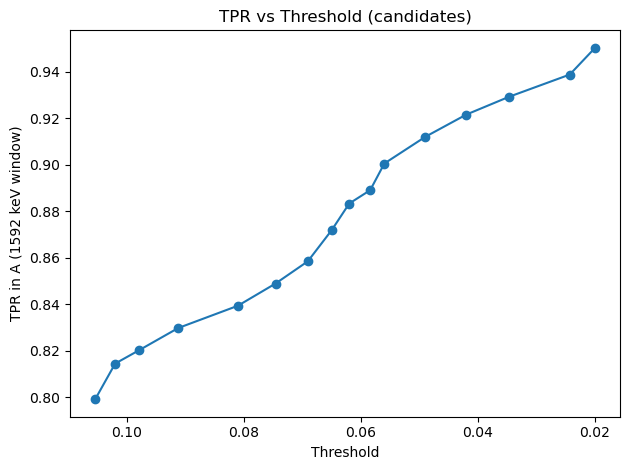

In [7]:
# ============================================================
# Step 1.5: Candidate thresholds that automatically satisfy TPR >= 0.80
# ============================================================
TPR_GRID = np.linspace(MIN_TPR, 0.95, 16) 
THR_GRID = np.array([thr_from_target_tpr(scores_signal, tpr) for tpr in TPR_GRID], dtype=float)

# sanity check
TPR_CHECK = np.array([tpr_from_scores(scores_signal, thr) for thr in THR_GRID], dtype=float)

for tpr_target, thr, tpr_real in zip(TPR_GRID[:], THR_GRID[:], TPR_CHECK[:]):
    print(f"target_tpr={tpr_target:.3f} -> thr={thr:.6f}, achieved_tpr={tpr_real:.6f}")

plt.figure()
plt.plot(THR_GRID, TPR_CHECK, marker="o")
plt.gca().invert_xaxis() 
plt.xlabel("Threshold")
plt.ylabel("TPR in A (1592 keV window)")
plt.title("TPR vs Threshold (candidates)")
plt.tight_layout()
plt.show()


## Step 3:
Detector B

In [8]:
def get_window_scores(df: pd.DataFrame, center_keV: float, half_width: float) -> np.ndarray:
    m = window_mask(df["energy"].values, center_keV, half_width)
    return df.loc[m, "classificationscore"].values

def rate_from_scores(scores_window: np.ndarray, thr: float) -> float:
    return float((scores_window >= thr).mean()) if len(scores_window) else 0.0

,tpr_target,thr,TPR_A1592,FPR_B2103
15,0.95,0.0200,0.9503,0.6230
14,0.94,0.0243,0.9388,0.5722
13,0.93,0.0347,0.9293,0.4746
12,0.92,0.0420,0.9216,0.4184
11,0.91,0.0490,0.9120,0.3757
10,0.90,0.0560,0.9006,0.3356
9,0.89,0.0584,0.8891,0.3222
8,0.88,0.0620,0.8834,0.3115
7,0.87,0.0650,0.8719,0.3008
6,0.86,0.0691,0.8585,0.2834


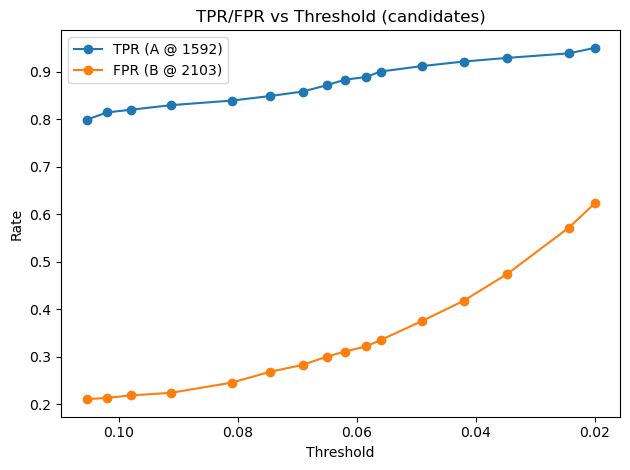

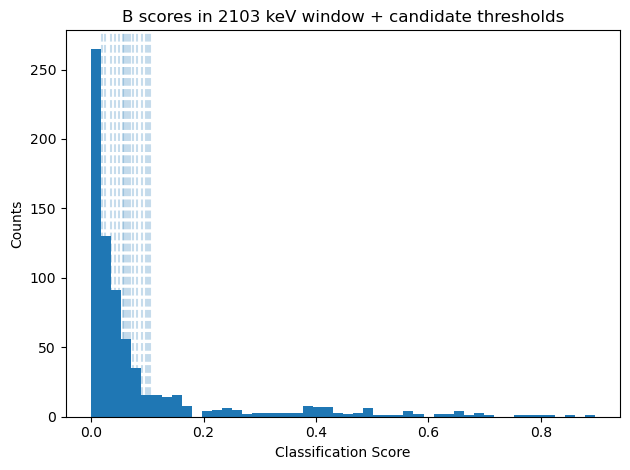

In [9]:
# ==========================================================
# Step 2: Compute FPR for each candidate threshold using B's 2103 keV peak
# ==========================================================
BKG_KEV = 2103.0

# cache B window scores once
scores_bkg = get_window_scores(B, BKG_KEV, PEAK_HALF_WIDTH)
if len(scores_bkg) == 0:
    raise ValueError("No events in B background window. Increase PEAK_HALF_WIDTH or check data.")

# for each candidate threshold compute FPR
FPR_GRID = np.array([rate_from_scores(scores_bkg, thr) for thr in THR_GRID], dtype=float)

# also compute achieved TPR for each threshold (sanity)
TPR_ACH_GRID = np.array([rate_from_scores(scores_signal, thr) for thr in THR_GRID], dtype=float)

# show a table
df_cutscan = pd.DataFrame({
    "tpr_target": TPR_GRID,
    "thr": THR_GRID,
    "TPR_A1592": TPR_ACH_GRID,
    "FPR_B2103": FPR_GRID,
}).sort_values("thr")  # thr increasing (more strict)

display(df_cutscan)

# plot TPR/FPR vs threshold
plt.figure()
plt.plot(THR_GRID, TPR_ACH_GRID, marker="o", label="TPR (A @ 1592)")
plt.plot(THR_GRID, FPR_GRID, marker="o", label="FPR (B @ 2103)")
plt.gca().invert_xaxis()  # higher thr -> lower rates, flip for intuition
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("TPR/FPR vs Threshold (candidates)")
plt.legend()
plt.tight_layout()
plt.show()

# show the B-window score histogram once, with all candidate thresholds overlaid
plt.figure()
plt.hist(scores_bkg, bins=50)
for thr in THR_GRID:
    plt.axvline(thr, linestyle="--", alpha=0.25)
plt.xlabel("Classification Score")
plt.ylabel("Counts")
plt.title("B scores in 2103 keV window + candidate thresholds")
plt.tight_layout()
plt.show()

Kept 11/16 candidates after filtering.


,tpr_target,thr,TPR_A1592,FPR_B2103
11,0.91,0.0490,0.9120,0.3757
10,0.90,0.0560,0.9006,0.3356
9,0.89,0.0584,0.8891,0.3222
8,0.88,0.0620,0.8834,0.3115
7,0.87,0.0650,0.8719,0.3008
6,0.86,0.0691,0.8585,0.2834
5,0.85,0.0746,0.8489,0.2687
4,0.84,0.0810,0.8394,0.2460
3,0.83,0.0912,0.8298,0.2246
2,0.82,0.0979,0.8203,0.2193


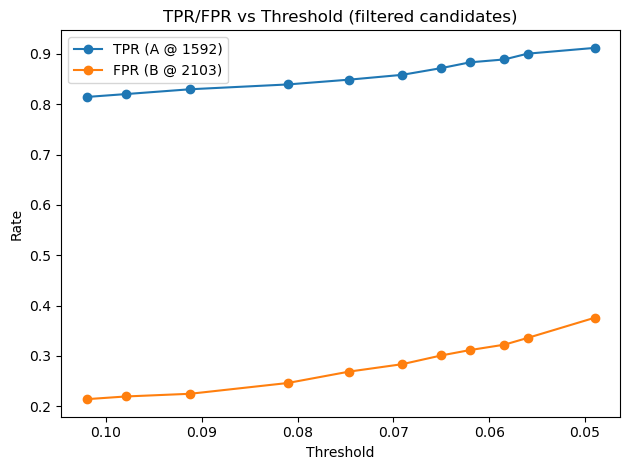

In [10]:
# ==========================================================
# Step 2.5: Filter candidates (cheap pruning before expensive fits)
# constrains: FPR <= 0.4 && TPR >= 0.8
# ==========================================================
MAX_FPR = 0.40
MIN_TPR = 0.80  

df_filt = df_cutscan[
    (df_cutscan["TPR_A1592"] >= MIN_TPR) &
    (df_cutscan["FPR_B2103"] <= MAX_FPR)
].copy().sort_values("thr")  # thr increasing = stricter

print(f"Kept {len(df_filt)}/{len(df_cutscan)} candidates after filtering.")
display(df_filt)

# update candidate arrays for next steps (very important!)
THR_GRID_F = df_filt["thr"].to_numpy()
TPR_TARGET_F = df_filt["tpr_target"].to_numpy()
TPR_ACH_F = df_filt["TPR_A1592"].to_numpy()
FPR_F = df_filt["FPR_B2103"].to_numpy()

# visualize filtered set
plt.figure()
plt.plot(THR_GRID_F, TPR_ACH_F, marker="o", label="TPR (A @ 1592)")
plt.plot(THR_GRID_F, FPR_F, marker="o", label="FPR (B @ 2103)")
plt.gca().invert_xaxis()
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("TPR/FPR vs Threshold (filtered candidates)")
plt.legend()
plt.tight_layout()
plt.show()


## Step 4:


In [11]:
def gaussian_bin_probs(edges: np.ndarray, mu: float, sigma: float) -> np.ndarray:
    cdf_hi = norm.cdf(edges[1:], loc=mu, scale=sigma)
    cdf_lo = norm.cdf(edges[:-1], loc=mu, scale=sigma)
    p = np.maximum(cdf_hi - cdf_lo, 0.0)
    s = p.sum()
    if s <= 0:
        raise ValueError("Gaussian template has zero mass in the chosen range/bins.")
    return p / s

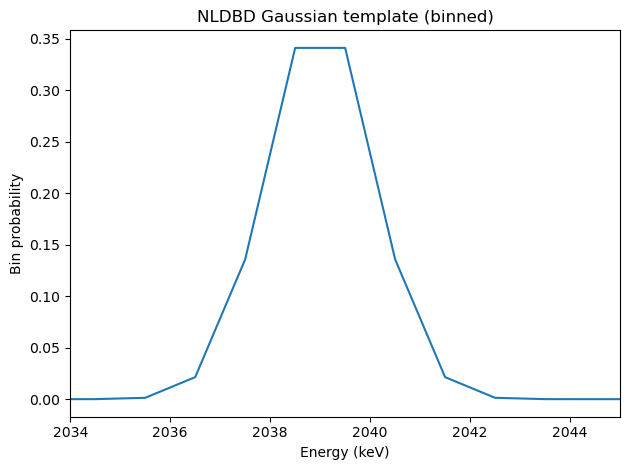

In [12]:
# ==========================================================
# Step 4: Build NLDBD PDF as Gaussian at 2039 keV (width ±1 keV)
# ==========================================================
NLDBD_KEV = 2039.0
NLDBD_SIGMA = 1.0   # interpret "±1 keV" as sigma=1 keV (state this in report)

EMIN, EMAX, BINW = 500.0, 3000.0, 1.0
edges = np.arange(EMIN, EMAX + BINW, BINW)
centers = 0.5 * (edges[:-1] + edges[1:])

pN = gaussian_bin_probs(edges, NLDBD_KEV, NLDBD_SIGMA)

plt.figure()
plt.plot(centers, pN)
plt.xlim(2034, 2045)
plt.xlabel("Energy (keV)")
plt.ylabel("Bin probability")
plt.title("NLDBD Gaussian template (binned)")
plt.tight_layout()
plt.show()


## Step 5:

In [13]:
# ==========================================================
# Step 5: Functions (apply cut -> build templates -> plots comparison with/without cut)
# ==========================================================
def apply_cut(df: pd.DataFrame, thr: float) -> pd.DataFrame:
    """Keep events with classificationscore >= thr."""
    return df[df["classificationscore"] >= thr].copy()

def make_hist_counts(energies: np.ndarray, edges: np.ndarray) -> np.ndarray:
    """Binned counts (float) for a given energy array and bin edges."""
    counts, _ = np.histogram(energies, bins=edges)
    return counts.astype(float)

def make_pdf_from_counts(counts: np.ndarray) -> np.ndarray:
    """Normalize counts into a probability vector (sums to 1)."""
    s = float(np.sum(counts))
    if s <= 0:
        raise ValueError("Empty histogram; check energy range / cut threshold.")
    return counts / s

def build_templates_for_thr(
    A: pd.DataFrame,
    B: pd.DataFrame,
    C: pd.DataFrame,
    T: pd.DataFrame,
    thr: float,
    edges: np.ndarray,
    *,
    return_cut_dfs: bool = False
):
    """
    Apply cut at threshold thr, then build:
      y  : Target histogram counts (NOT normalized)
      pA : normalized template from A after cut
      pB : normalized template from B after cut
      pC : normalized template from C after cut

    If return_cut_dfs=True, also returns (A2,B2,C2,T2).
    """
    # apply cut
    A2 = apply_cut(A, thr)
    B2 = apply_cut(B, thr)
    C2 = apply_cut(C, thr)
    T2 = apply_cut(T, thr)

    # target counts
    y = make_hist_counts(T2["energy"].values, edges)

    # templates
    pA = make_pdf_from_counts(make_hist_counts(A2["energy"].values, edges))
    pB = make_pdf_from_counts(make_hist_counts(B2["energy"].values, edges))
    pC = make_pdf_from_counts(make_hist_counts(C2["energy"].values, edges))

    if return_cut_dfs:
        return y, pA, pB, pC, A2, B2, C2, T2
    return y, pA, pB, pC

# ---------------- plotting helpers ----------------

def plot_before_after_grid(dfs_before, dfs_after, labels, bins=450, xlim=(1000, 3500)):
    """
    2x2 grid. Each panel overlays before cut vs after cut energy spectra.
    dfs_before/after: list of 4 dataframes [A,B,C,T] and [A2,B2,C2,T2]
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)
    axes = axes.ravel()

    for ax, df0, df1, lab in zip(axes, dfs_before, dfs_after, labels):
        ax.hist(df0["energy"], bins=bins, range=xlim, histtype="step", label="before cut")
        ax.hist(df1["energy"], bins=bins, range=xlim, histtype="step", label="after cut")
        ax.set_title(lab)
        ax.set_xlim(*xlim)
        ax.set_xlabel("Energy (keV)")
        ax.set_ylabel("Counts")
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_templates_roi(centers, y, pA, pB, pC, pN, roi=(1900, 2200)):
    """
    Quick ROI view:
      - pA/pB/pC/pN shapes
      - y counts
    """
    lo, hi = roi

    plt.figure()
    plt.plot(centers, pA, label="pA")
    plt.plot(centers, pB, label="pB")
    plt.plot(centers, pC, label="pC")
    plt.plot(centers, pN, label="pNLDBD")
    plt.xlim(lo, hi)
    plt.xlabel("Energy (keV)")
    plt.ylabel("PDF (shape)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.step(centers, y, where="mid")
    plt.xlim(lo, hi)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Target counts / bin")
    plt.title("Target histogram after cut")
    plt.tight_layout()
    plt.show()


In [14]:
# ==========================================================
# Step 5: Build (y, pA, pB, pC) for each candidate threshold
# ==========================================================
templates_by_thr = {}   # thr -> dict(y,pA,pB,pC, sizes...)
rows = []

for thr_i in THR_GRID_F:
    try:
        y, pA, pB, pC, A2, B2, C2, T2 = build_templates_for_thr(
            A, B, C, T, float(thr_i), edges, return_cut_dfs=True
        )

        templates_by_thr[float(thr_i)] = {
            "y": y,
            "pA": pA, "pB": pB, "pC": pC,
            "A2_n": len(A2), "B2_n": len(B2), "C2_n": len(C2), "T2_n": len(T2),
            "y_sum": float(np.sum(y)),
        }

        rows.append({
            "thr": float(thr_i),
            "A2_n": len(A2), "B2_n": len(B2), "C2_n": len(C2), "T2_n": len(T2),
            "Target_counts_sum": float(np.sum(y)),
        })

    except Exception as e:
        rows.append({
            "thr": float(thr_i),
            "error": str(e),
        })

df_step5 = pd.DataFrame(rows).sort_values("thr")
display(df_step5)
print("Built templates for", sum("error" not in r for r in rows), "thresholds.")



,thr,A2_n,B2_n,C2_n,T2_n,Target_counts_sum
0,0.0490,24886,24931,24834,3036,3035.0
1,0.0560,23734,23758,23614,2899,2898.0
2,0.0584,23257,23281,23180,2840,2839.0
3,0.0620,22801,22836,22724,2793,2793.0
4,0.0650,22374,22398,22312,2742,2742.0
5,0.0691,21722,21727,21681,2686,2686.0
6,0.0746,21083,21137,21122,2609,2609.0
7,0.0810,20268,20391,20341,2504,2504.0
8,0.0912,19314,19420,19393,2380,2380.0
9,0.0979,18786,18891,18853,2311,2311.0


Built templates for 11 thresholds.


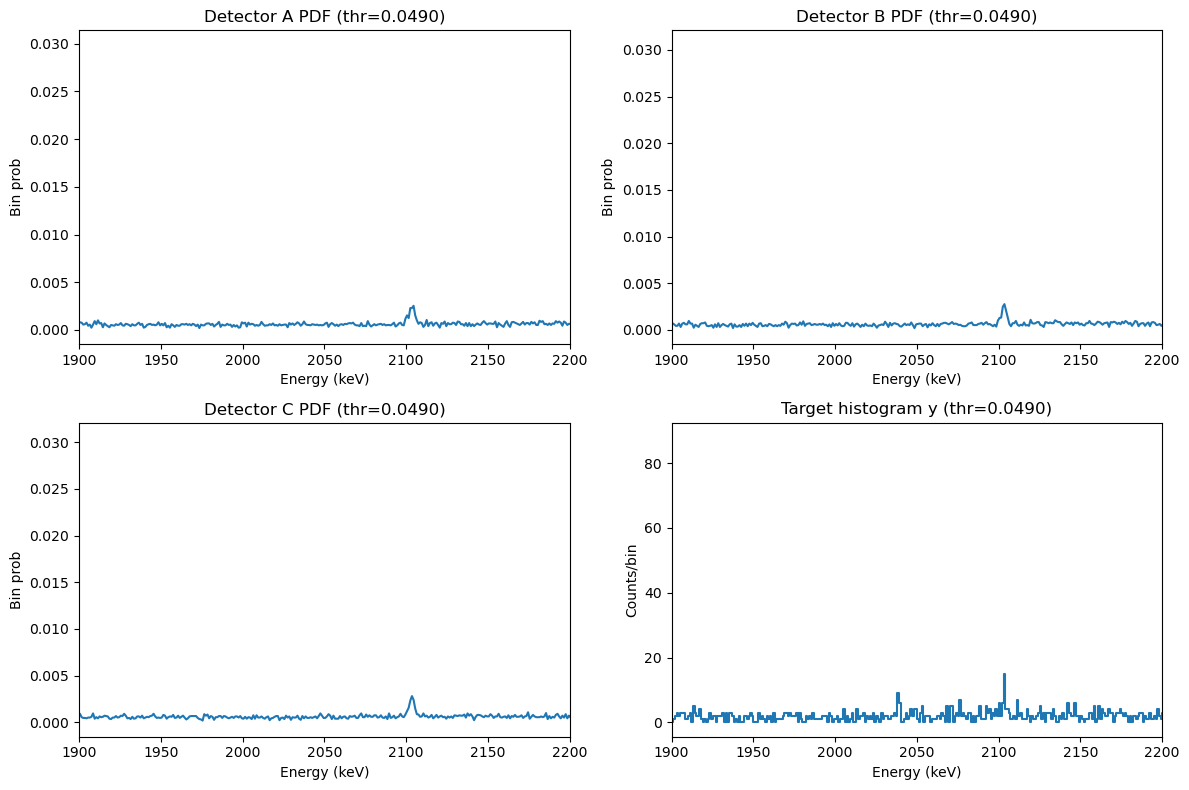

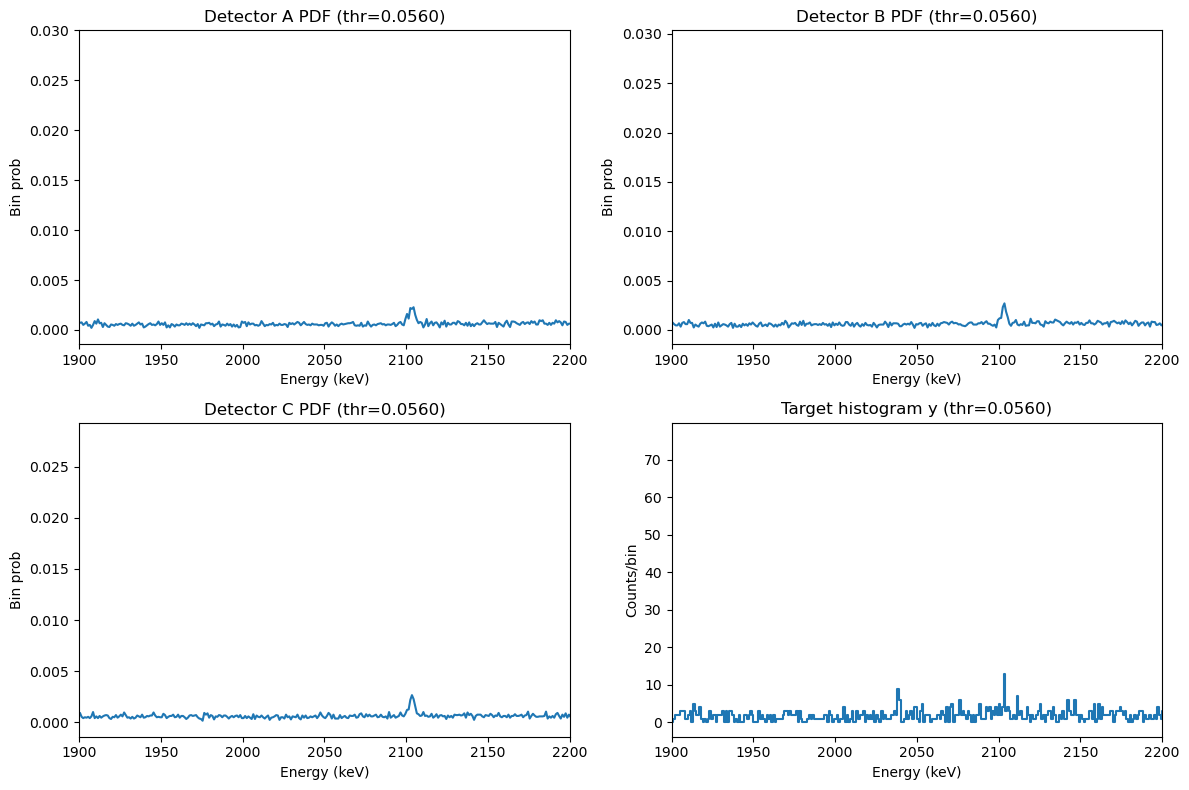

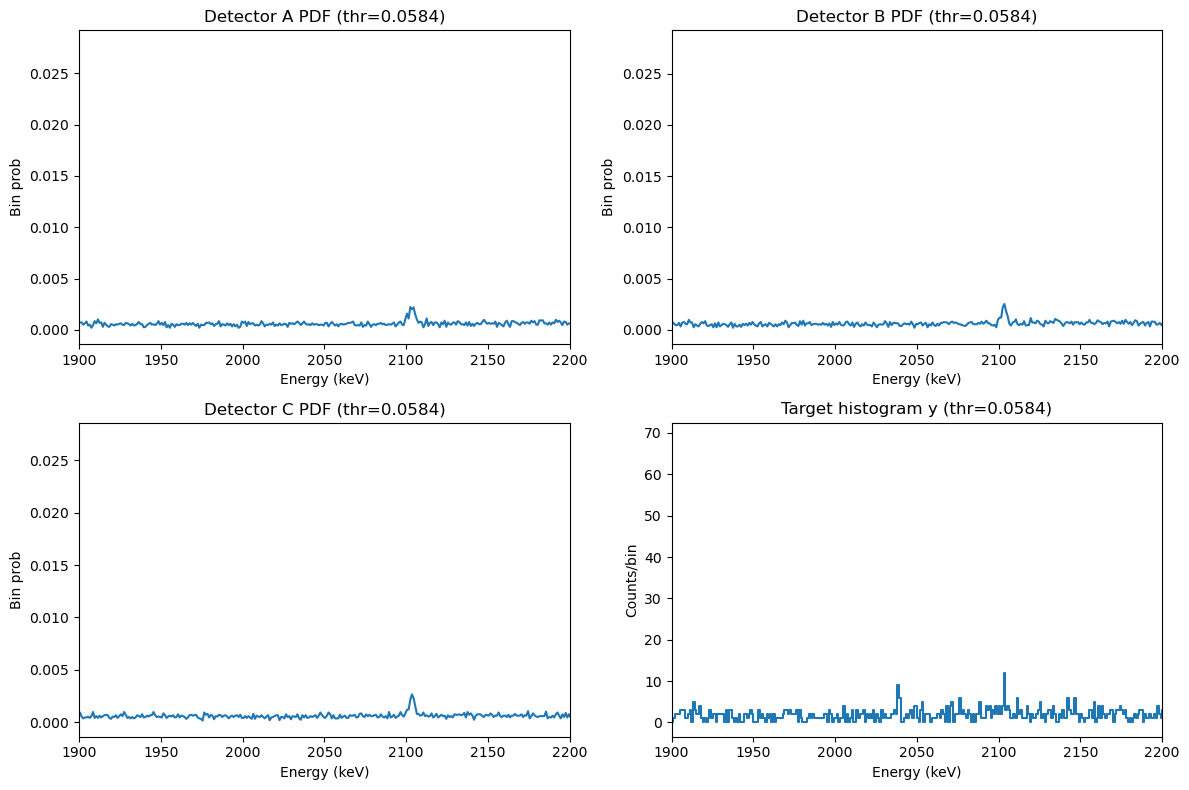

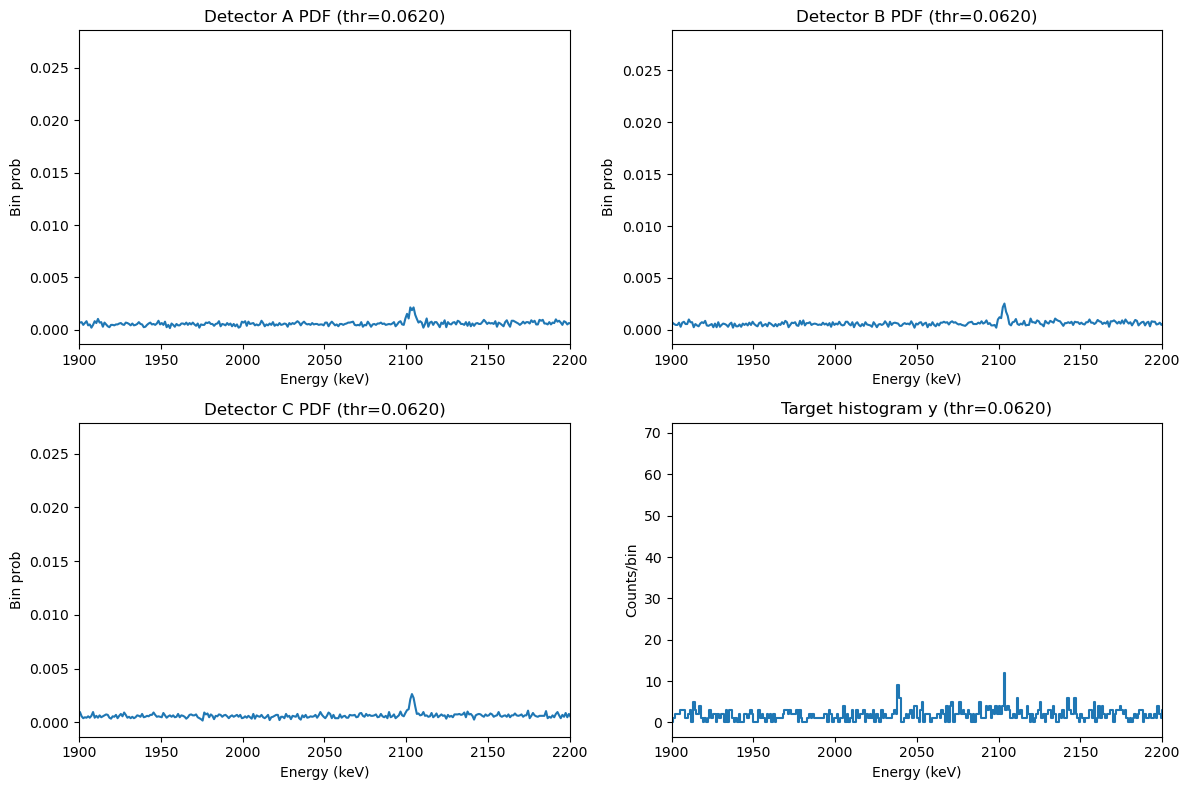

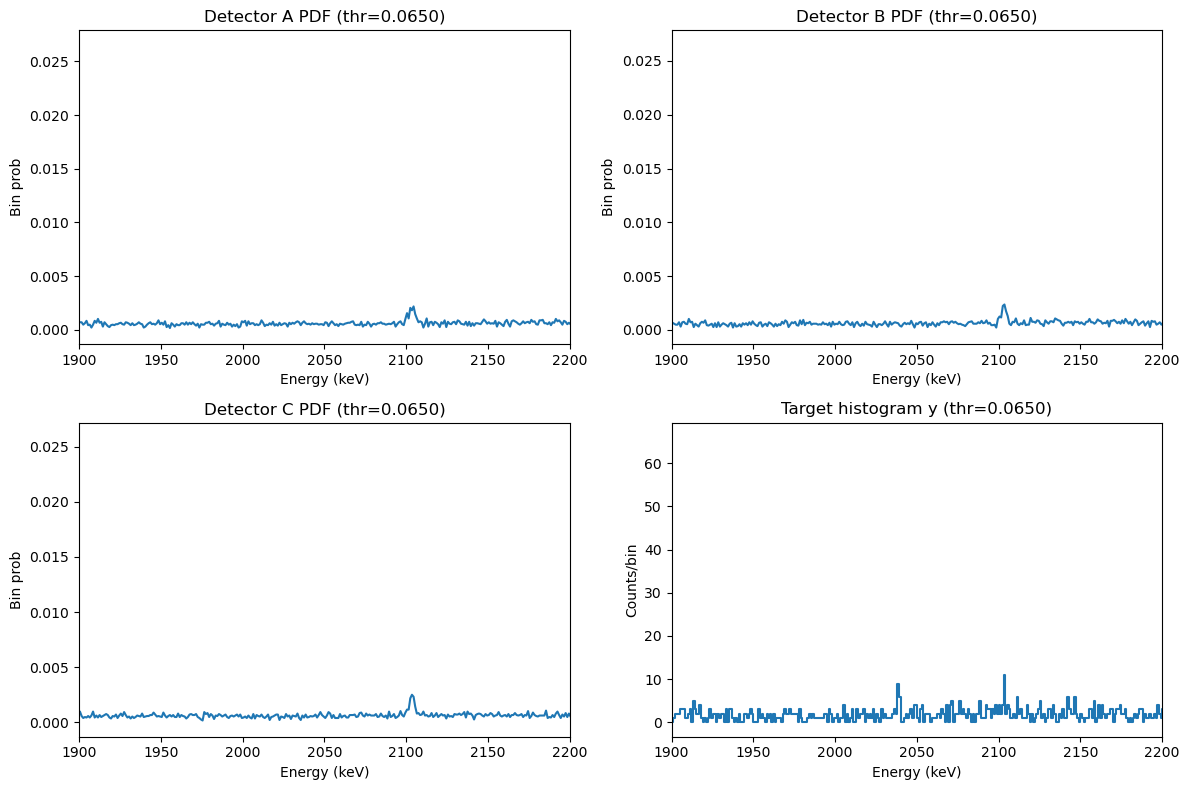

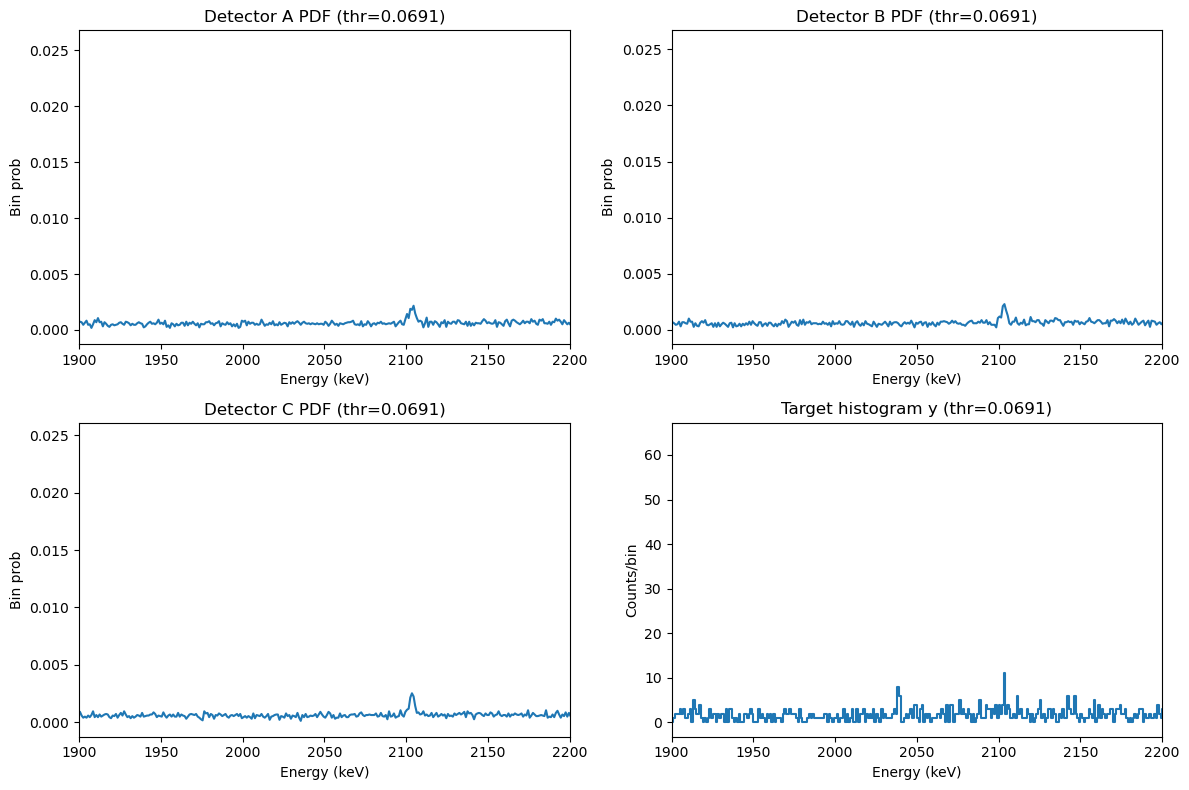

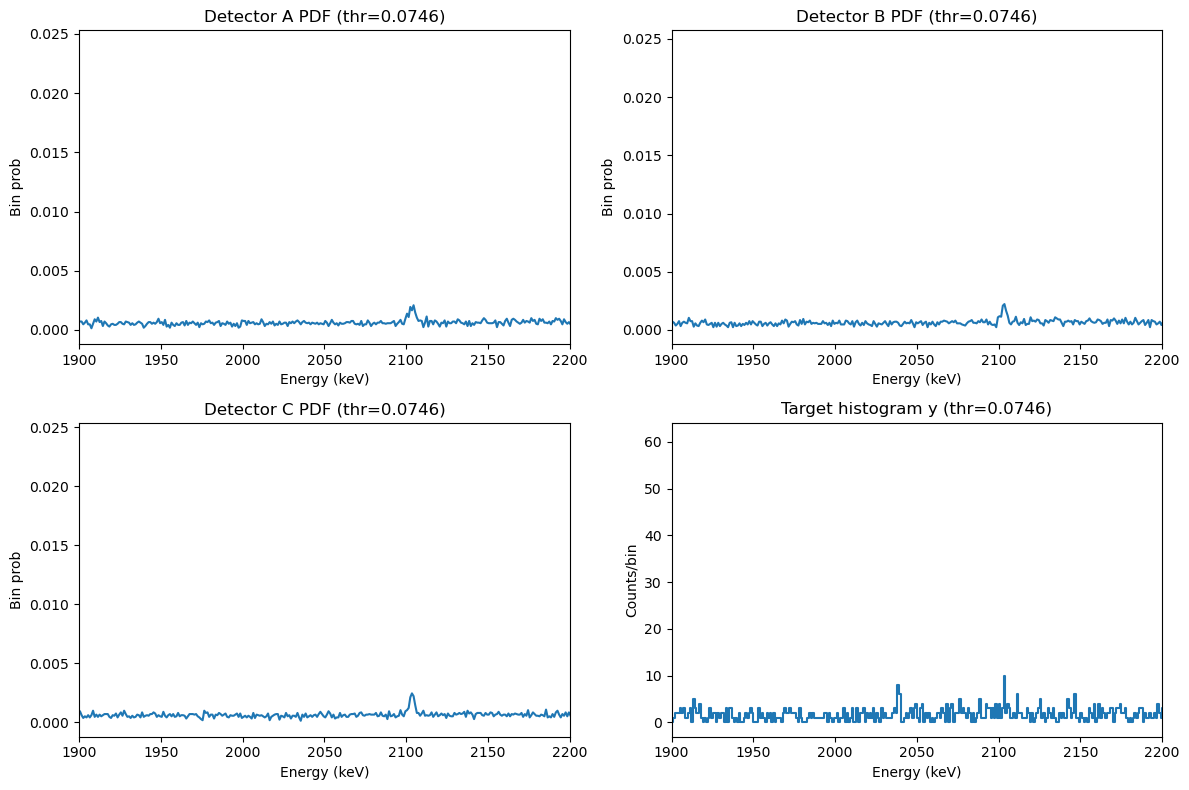

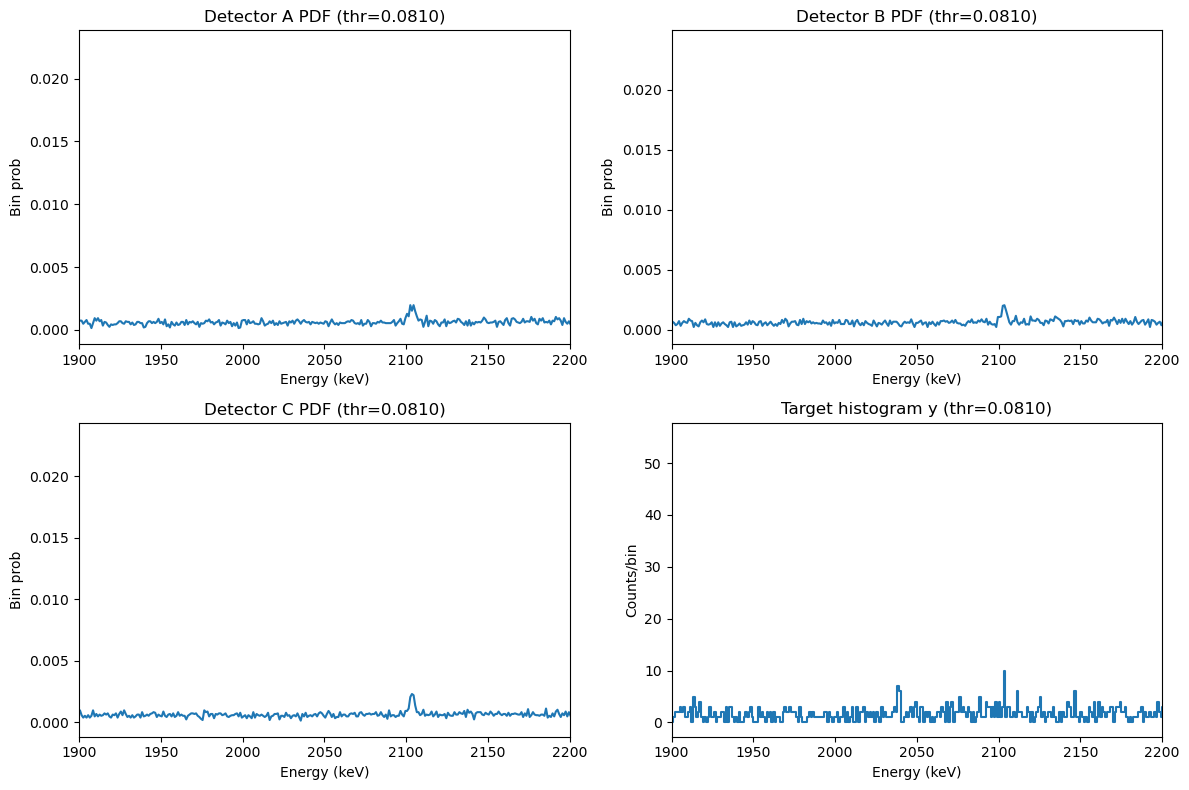

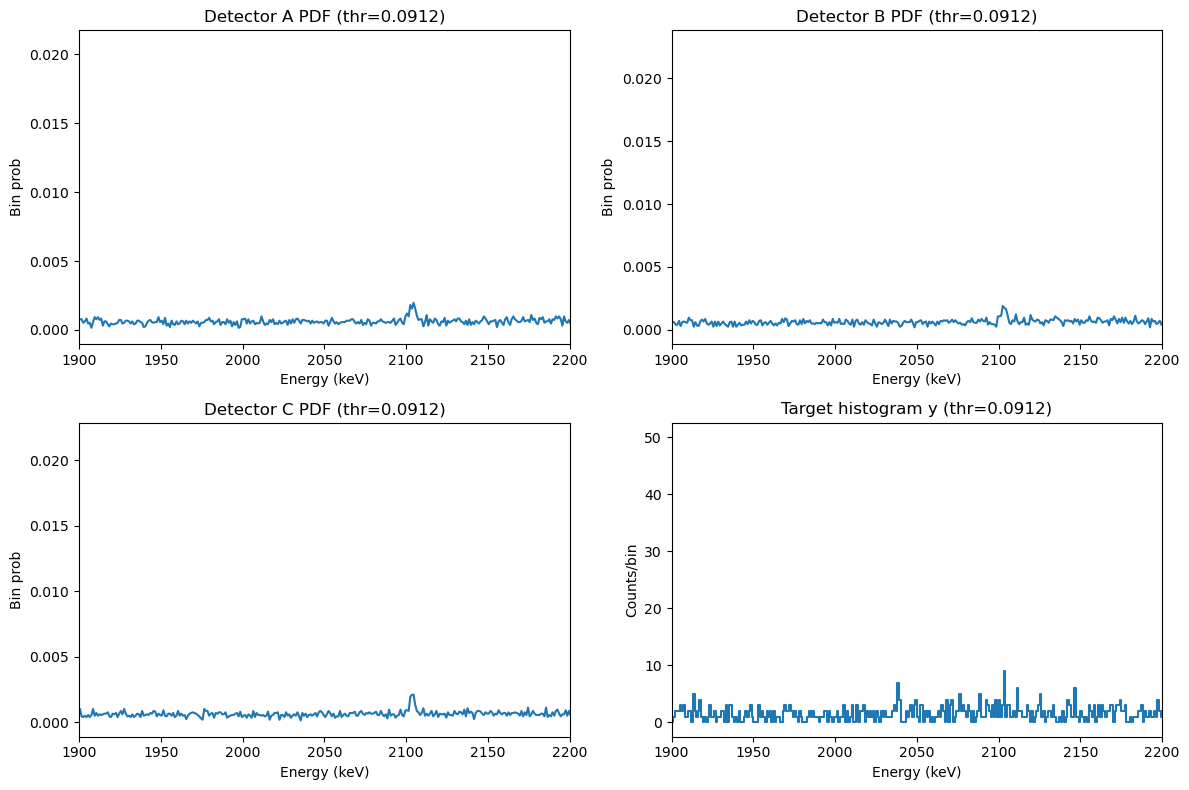

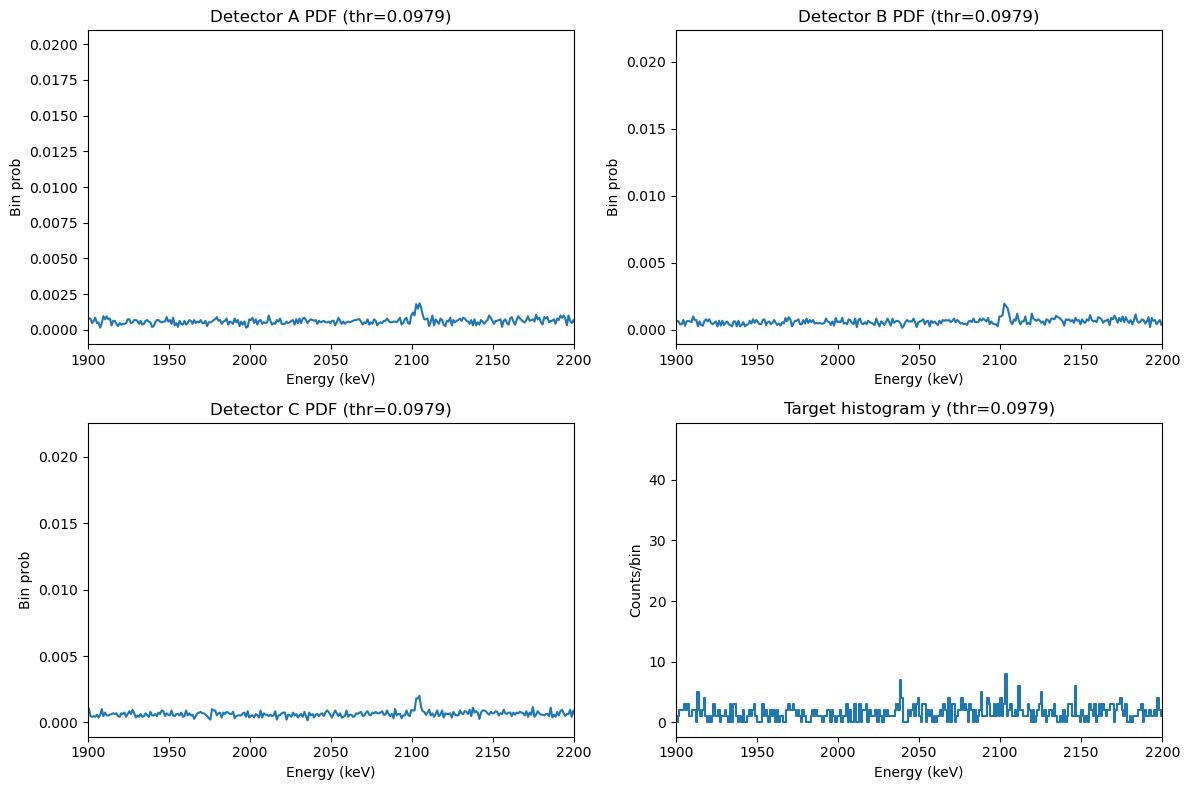

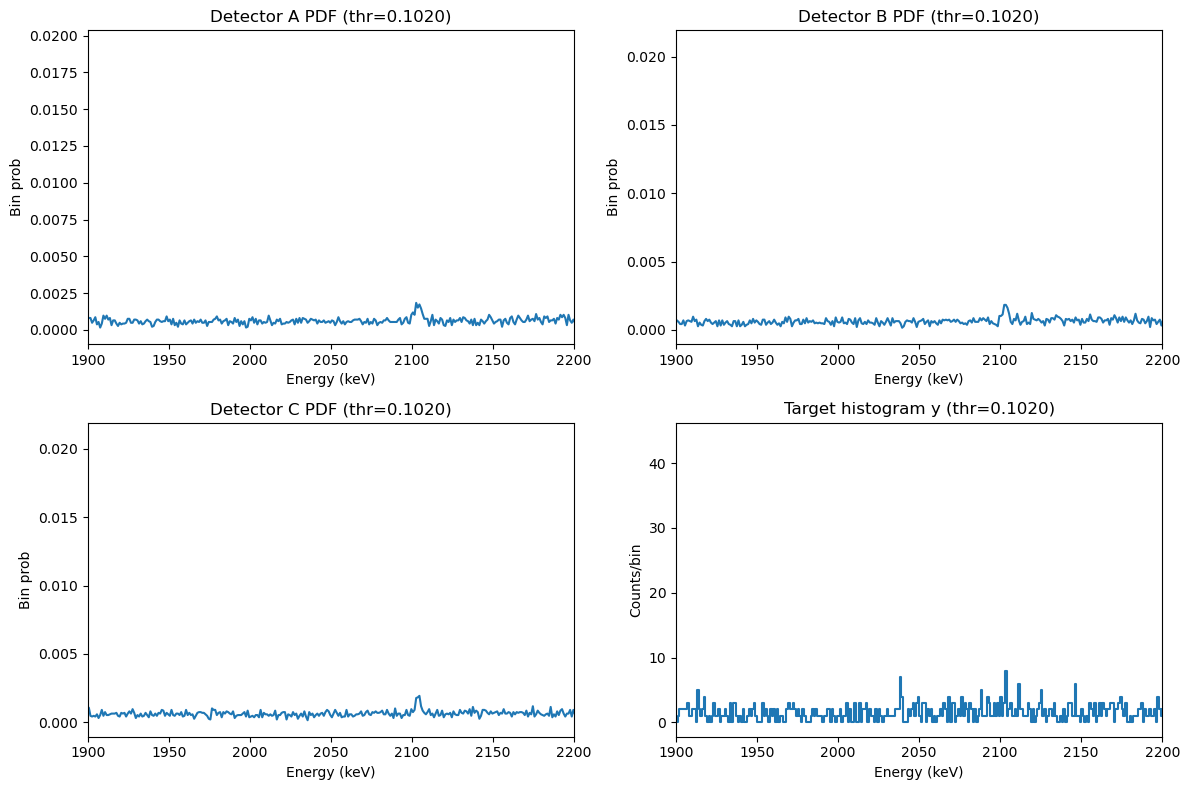

In [15]:
# ==========================================================
# Step 5 plotting: for each candidate threshold, plot pA/pB/pC and target y (2x2)
# ==========================================================
def plot_step5_one_thr(thr_pick: float, templates_by_thr: dict,
                       centers: np.ndarray, roi=(1900, 2200)):
    pack = templates_by_thr[thr_pick]
    pA, pB, pC, y = pack["pA"], pack["pB"], pack["pC"], pack["y"]

    lo, hi = roi
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()

    # A PDF
    axes[0].plot(centers, pA)
    axes[0].set_title(f"Detector A PDF (thr={thr_pick:.4f})")
    axes[0].set_xlim(lo, hi)
    axes[0].set_xlabel("Energy (keV)")
    axes[0].set_ylabel("Bin prob")

    # B PDF
    axes[1].plot(centers, pB)
    axes[1].set_title(f"Detector B PDF (thr={thr_pick:.4f})")
    axes[1].set_xlim(lo, hi)
    axes[1].set_xlabel("Energy (keV)")
    axes[1].set_ylabel("Bin prob")

    # C PDF
    axes[2].plot(centers, pC)
    axes[2].set_title(f"Detector C PDF (thr={thr_pick:.4f})")
    axes[2].set_xlim(lo, hi)
    axes[2].set_xlabel("Energy (keV)")
    axes[2].set_ylabel("Bin prob")

    # Target histogram counts
    axes[3].step(centers, y, where="mid")
    axes[3].set_title(f"Target histogram y (thr={thr_pick:.4f})")
    axes[3].set_xlim(lo, hi)
    axes[3].set_xlabel("Energy (keV)")
    axes[3].set_ylabel("Counts/bin")

    plt.tight_layout()
    plt.show()

# plot all candidates
ROI = (1900, 2200)  # or (1000, 3500) if you want full range (will look flat)
for thr_i in THR_GRID_F:
    plot_step5_one_thr(float(thr_i), templates_by_thr, centers, roi=ROI)


## Step 6:


In [24]:
# -----------------------------
# Step 6: fit function
# -----------------------------
def fit_target(
    y, pA, pB, pC, pN,
    thetaA_mu=THETA_A_MU, thetaA_sig=THETA_A_SIG,
    thetaB_mu=THETA_B_MU, thetaB_sig=THETA_B_SIG,
    use_calib_penalty=True
):
    total = float(np.sum(y))
    x0 = np.array([
        thetaA_mu,
        thetaB_mu,
        max(total - thetaA_mu - thetaB_mu, 10.0),
        0.0
    ], float)

    bounds = [(0, None), (0, None), (0, None), (0, None)]

    res = minimize(
        lambda x: nll_poisson_mixture(
            x, y, pA, pB, pC, pN,
            thetaA_mu, thetaA_sig, thetaB_mu, thetaB_sig,
            use_calib_penalty
        ),
        x0,
        method="L-BFGS-B",
        bounds=bounds
    )

    thetaA_hat, thetaB_hat, thetaC_hat, thetaN_hat = res.x
    mu_hat = thetaA_hat*pA + thetaB_hat*pB + thetaC_hat*pC + thetaN_hat*pN

    return {
        "success": bool(res.success),
        "fun": float(res.fun),
        "thetaA": float(thetaA_hat),
        "thetaB": float(thetaB_hat),
        "thetaC": float(thetaC_hat),
        "thetaN": float(thetaN_hat),
        "mu_hat": mu_hat,
        "res": res,
    }

# -----------------------------
# Step 6: plot helper
# -----------------------------
ROI = (1900, 2200)

def plot_target_vs_fit(centers, y, mu_hat, thr, roi=ROI, extra_title=""):
    lo, hi = roi
    plt.figure(figsize=(8, 4))
    plt.step(centers, y, where="mid", label="Target")
    plt.step(centers, mu_hat, where="mid", label="Fit")
    plt.xlim(lo, hi)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts / bin")
    ttl = f"Target vs Fit (thr={thr:.4f})"
    if extra_title:
        ttl += " | " + extra_title
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.show()

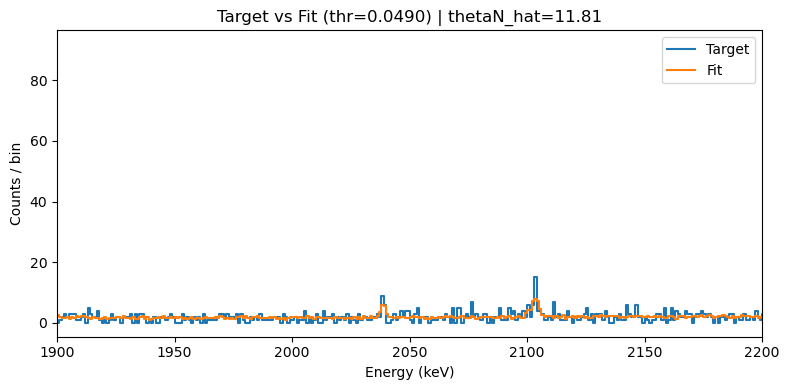

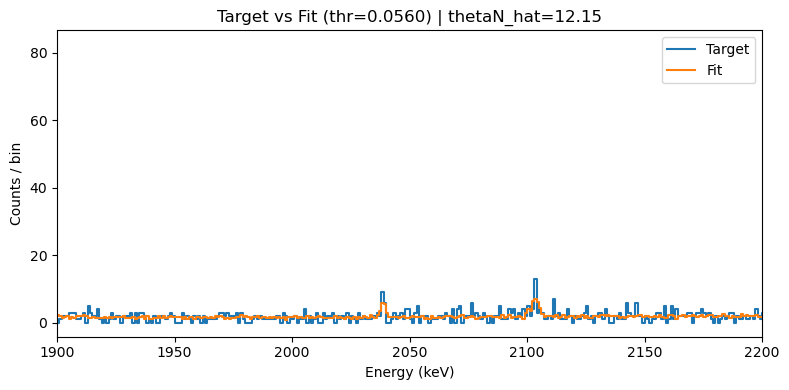

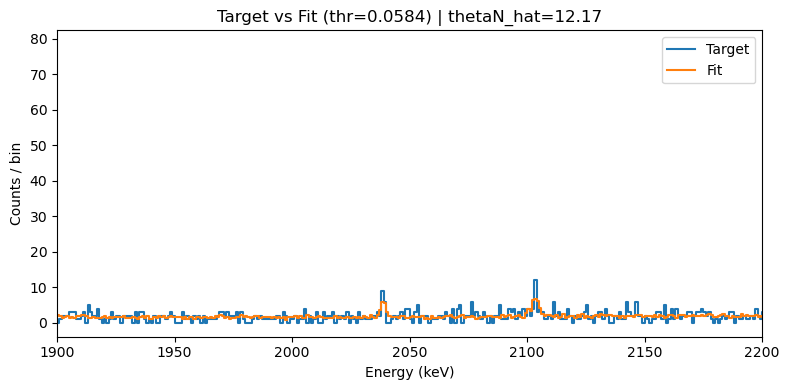

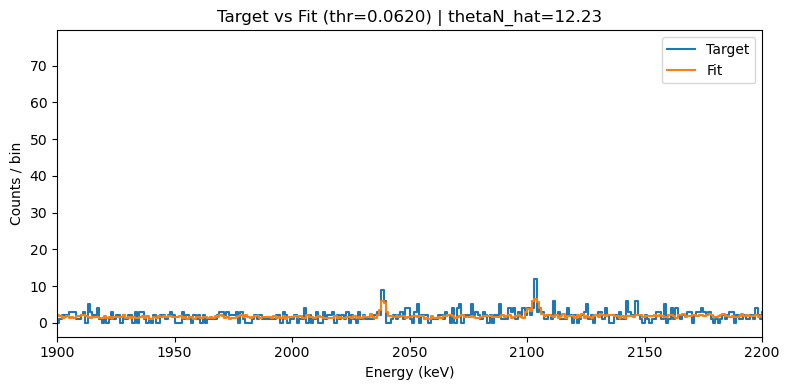

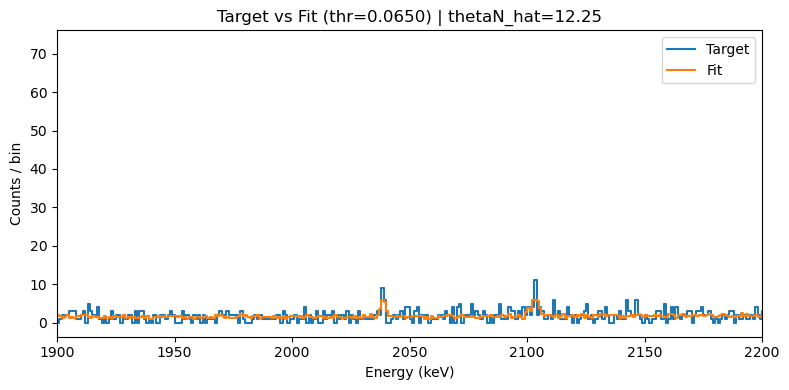

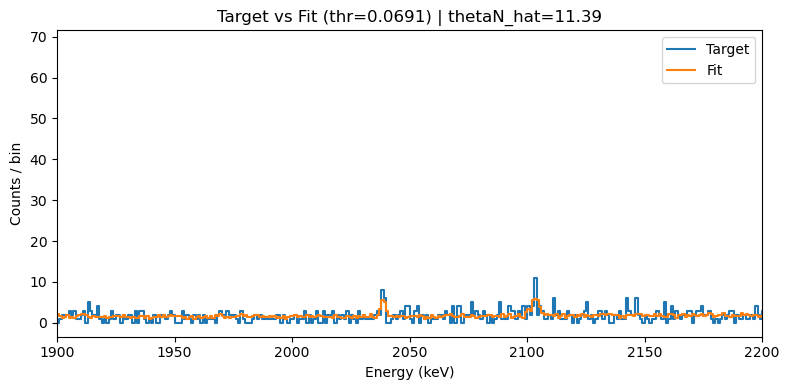

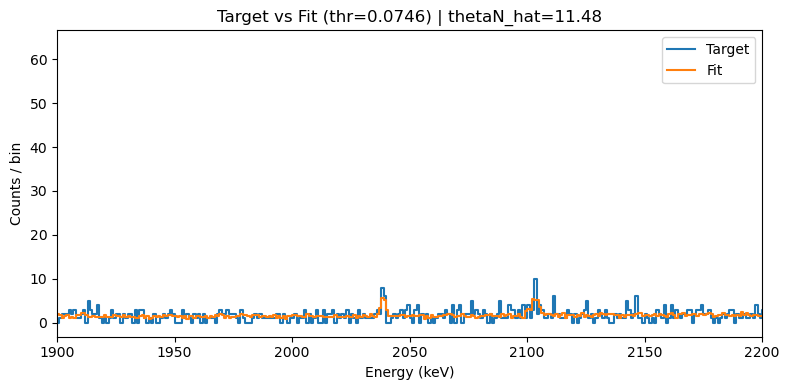

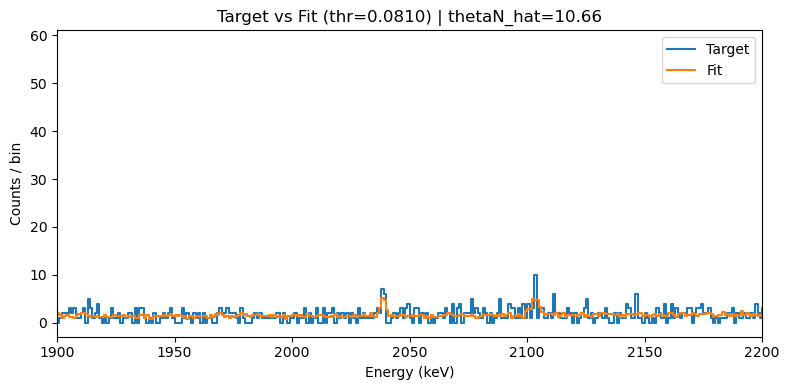

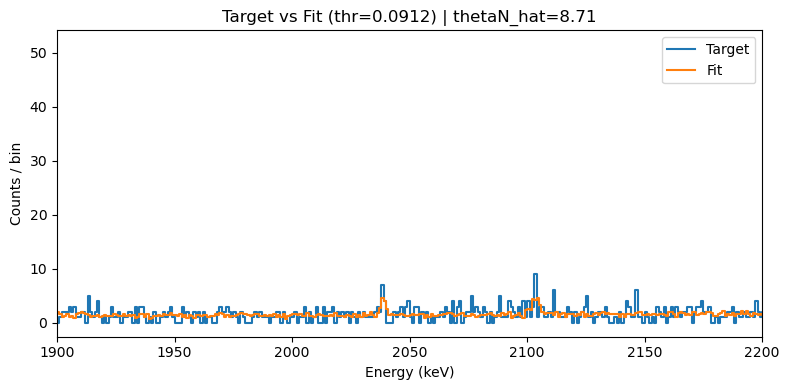

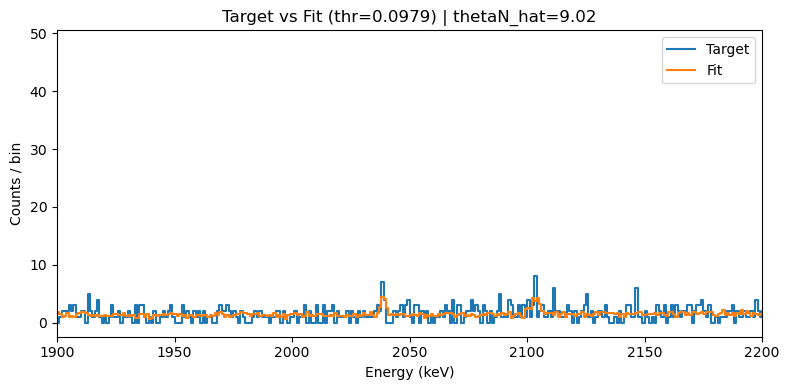

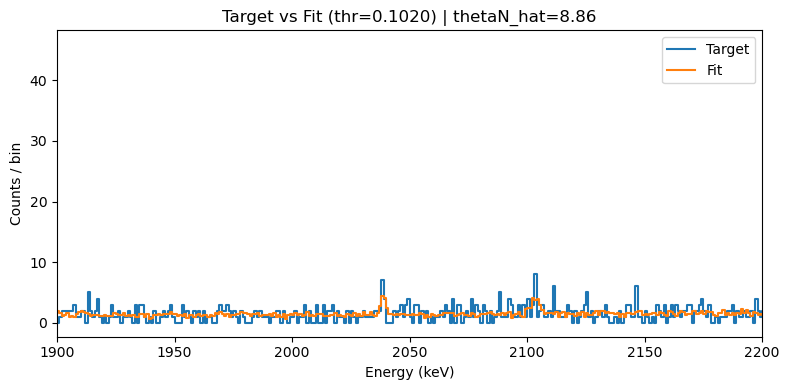

,thr,fit_success,nll_min,thetaA_hat,thetaB_hat,thetaC_hat,thetaN_hat,Target_counts_sum
0,0.0490,True,244.8738,1232.5620,879.0812,921.7690,11.8144,3035.0
1,0.0560,True,437.5416,1213.7459,878.1503,806.2143,12.1475,2898.0
2,0.0584,True,516.2531,1209.1993,877.2813,753.0480,12.1655,2839.0
3,0.0620,True,561.4315,1188.3163,872.4645,734.9684,12.2340,2793.0
4,0.0650,True,583.6953,1176.8650,886.3042,683.5515,12.2473,2742.0
5,0.0691,True,632.5966,1177.3962,881.2156,632.9353,11.3862,2686.0
6,0.0746,True,721.1752,1176.4767,889.8801,548.0998,11.4812,2609.0
7,0.0810,True,840.8847,1159.2380,825.6731,526.9052,10.6619,2504.0
8,0.0912,True,955.6276,1137.7890,741.8359,513.0929,8.7054,2380.0
9,0.0979,True,985.4946,1130.6443,710.4807,484.2139,9.0205,2311.0


In [25]:
# -----------------------------
# Step 6: apply ALL thresholds + plot + collect results
# -----------------------------
rows_step6 = []

for thr in THR_GRID_F:
    thr = float(thr)
    try:
        # Step5 for this thr
        y, pA, pB, pC = build_templates_for_thr(A, B, C, T, thr, edges)

        # Step6 fit
        fit = fit_target(y, pA, pB, pC, pN)

        rows_step6.append({
            "thr": thr,
            "fit_success": fit["success"],
            "nll_min": fit["fun"],
            "thetaA_hat": fit["thetaA"],
            "thetaB_hat": fit["thetaB"],
            "thetaC_hat": fit["thetaC"],
            "thetaN_hat": fit["thetaN"],
            "Target_counts_sum": float(np.sum(y)),
        })

        # plot (one per candidate)
        extra = f"thetaN_hat={fit['thetaN']:.2f}"
        plot_target_vs_fit(centers, y, fit["mu_hat"], thr, roi=ROI, extra_title=extra)

    except Exception as e:
        rows_step6.append({
            "thr": thr,
            "fit_success": False,
            "error": str(e),
        })
        print("thr failed:", thr, "| error:", e)

df_step6 = pd.DataFrame(rows_step6).sort_values("thr")
display(df_step6)

## Step 7:

In [26]:
Q_TARGET = 2.71 # Frequentist

def ul90_profile_for_templates(y, pA, pB, pC, pN,
                               thetaA_hat, thetaB_hat, thetaC_hat, thetaN_hat,
                               nll_min,
                               q_target=Q_TARGET,
                               make_plot=False,
                               plot_xlim=(0, 80),
                               n_grid=120):
    """
    Compute 90% UL on thetaN by profile likelihood:
      q(tN) = 2*(NLL_profile(tN) - NLL_min)
    Uses your existing profile_nll(...) that minimizes over (thetaA,thetaB,thetaC) for fixed tN.
    """

    x0_abc = np.array([thetaA_hat, thetaB_hat, thetaC_hat], float)

    def q_of_thetaN(tN):
        nll_t, _, _ = profile_nll(
            float(tN), y, pA, pB, pC, pN,
            THETA_A_MU, THETA_A_SIG, THETA_B_MU, THETA_B_SIG,
            x0_abc=x0_abc
        )
        q = 2.0 * (float(nll_t) - float(nll_min))
        return max(0.0, q)

    t0 = max(float(thetaN_hat), 0.0)
    eps = 1e-9

    # bracket UL on the right side of t0
    t_hi = max(10.0, t0 + 10.0)
    for _ in range(60):
        if q_of_thetaN(t_hi) >= q_target:
            break
        t_hi *= 2.0
    else:
        # failed to bracket
        ul90 = np.nan
        t_hi = float(t_hi)

    if np.isfinite(t_hi):
        try:
            ul90 = float(brentq(lambda t: q_of_thetaN(t) - q_target, t0 + eps, t_hi))
        except Exception:
            ul90 = np.nan

    # optional plot q curve
    if make_plot:
        xmax = max(plot_xlim[1], t_hi)
        grid = np.linspace(plot_xlim[0], xmax, n_grid)
        qs = np.array([q_of_thetaN(t) for t in grid], dtype=float)

        plt.figure(figsize=(7, 4))
        plt.plot(grid, qs)
        plt.axhline(q_target, linestyle="--", label="q=2.71")
        plt.axvline(t0, linestyle=":", label="thetaN_hat")
        if np.isfinite(ul90):
            plt.axvline(ul90, linestyle="--", label=f"UL90={ul90:.2f}")
        plt.xlabel(r"$\theta_{NLDBD}$")
        plt.ylabel(r"$q=-2\ln\lambda$")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return ul90

def profile_nll(thetaN_fixed, y, pA, pB, pC, pN,
                thetaA_mu, thetaA_sig, thetaB_mu, thetaB_sig,
                x0_abc=None,
                use_calib_penalty=True):
    """
    For a fixed thetaN, minimize NLL over (thetaA, thetaB, thetaC).
    Returns: (nll_min_profile, x_abc_hat, success)
    """
    thetaN_fixed = float(thetaN_fixed)

    if x0_abc is None:
        total = float(np.sum(y))
        x0_abc = np.array([thetaA_mu,
                           thetaB_mu,
                           max(total - thetaA_mu - thetaB_mu, 10.0)], float)
    x0_abc = np.array(x0_abc, float)

    bounds = [(0, None), (0, None), (0, None)]

    def obj(xabc):
        thetaA, thetaB, thetaC = xabc
        params = np.array([thetaA, thetaB, thetaC, thetaN_fixed], float)
        return nll_poisson_mixture(params, y, pA, pB, pC, pN,
                                   thetaA_mu, thetaA_sig, thetaB_mu, thetaB_sig,
                                   use_calib_penalty)

    res = minimize(obj, x0_abc, method="L-BFGS-B", bounds=bounds)
    return float(res.fun), res.x, bool(res.success)


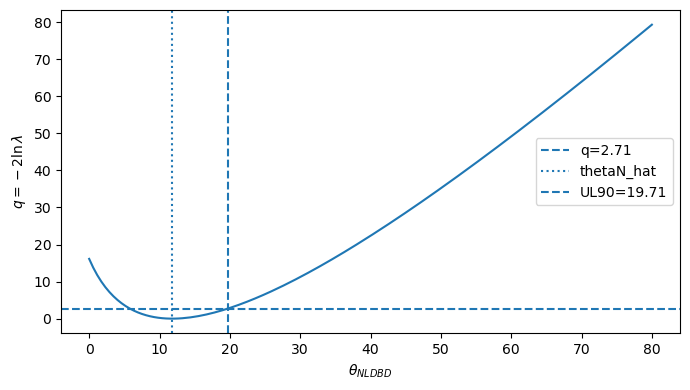

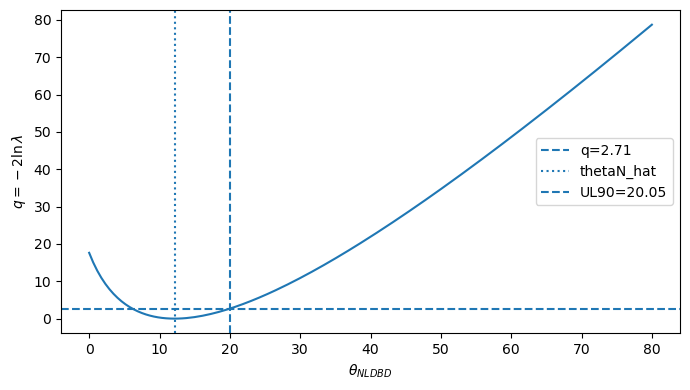

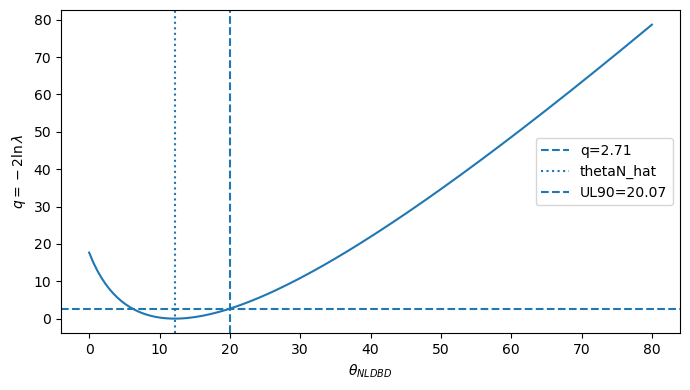

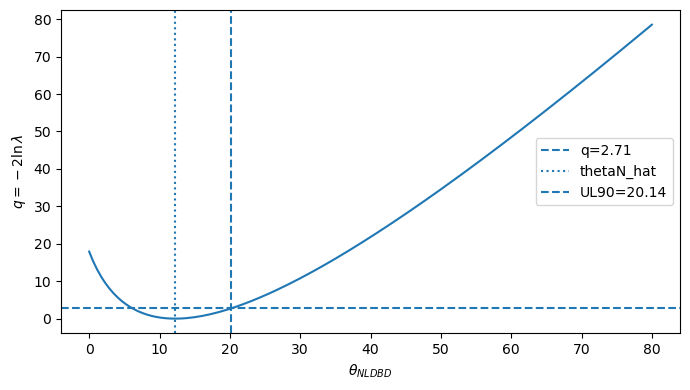

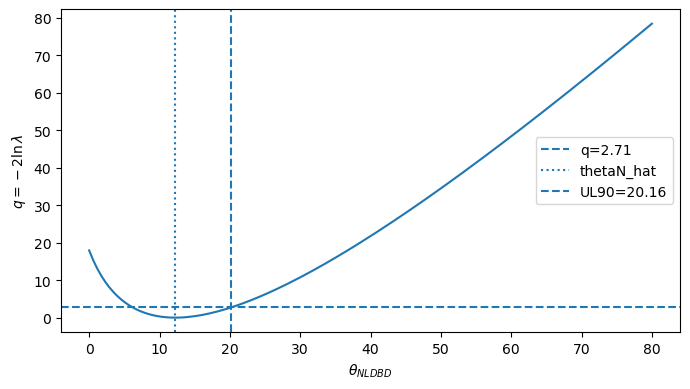

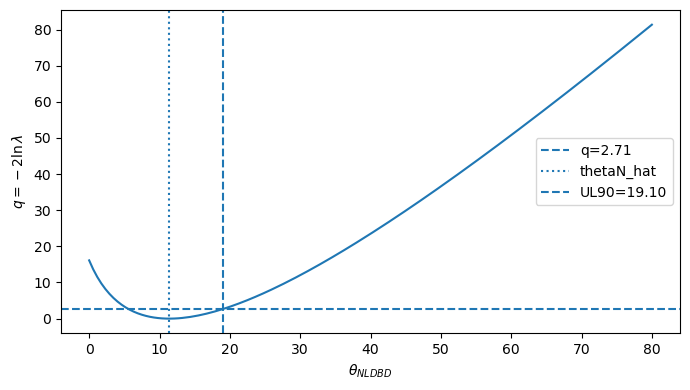

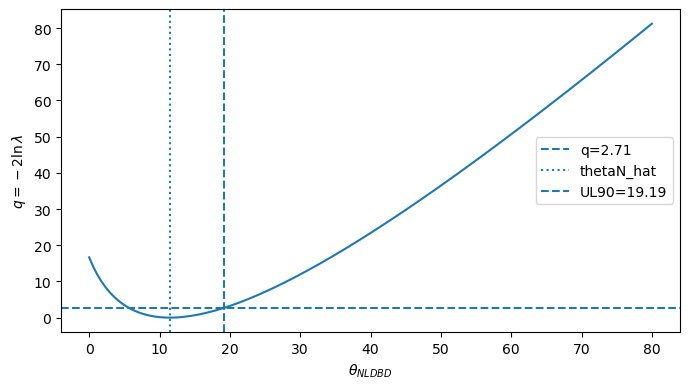

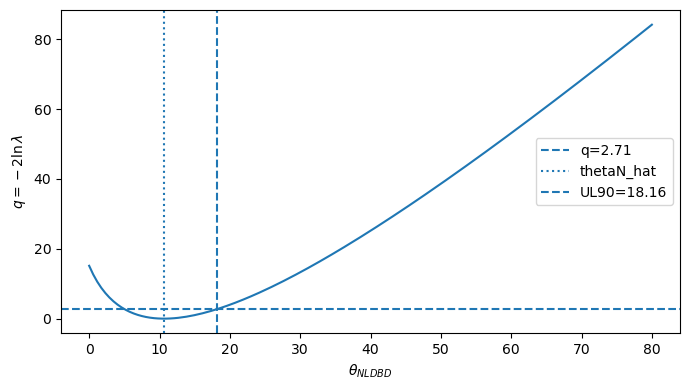

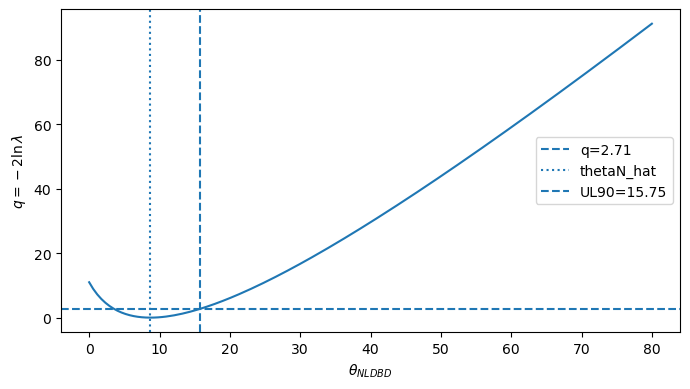

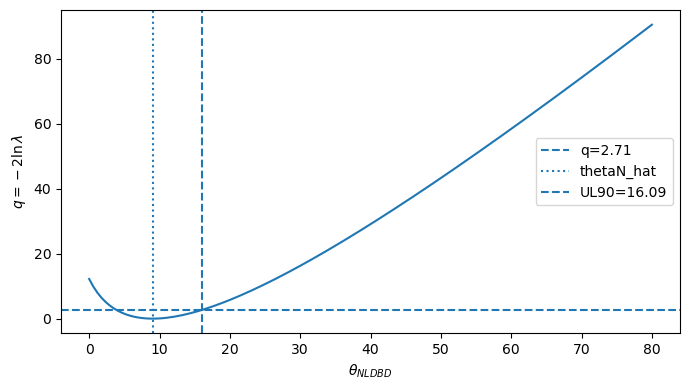

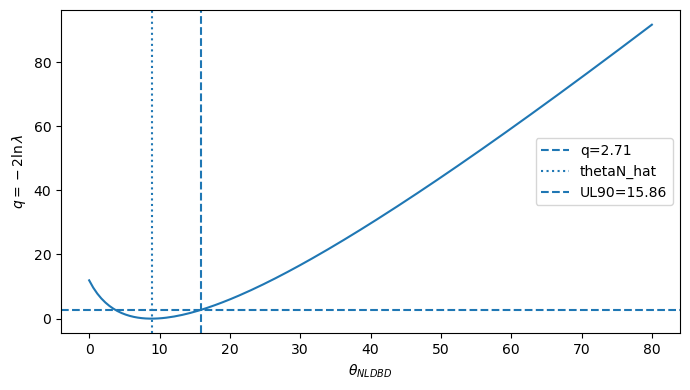

,tpr_target,thr,TPR_A1592,FPR_B2103,fit_success,thetaN_hat,UL90,nll_min
0,0.91,0.0490,0.9120,0.3757,True,11.8144,19.7063,244.8738
1,0.90,0.0560,0.9006,0.3356,True,12.1475,20.0511,437.5416
2,0.89,0.0584,0.8891,0.3222,True,12.1655,20.0678,516.2531
3,0.88,0.0620,0.8834,0.3115,True,12.2340,20.1391,561.4315
4,0.87,0.0650,0.8719,0.3008,True,12.2473,20.1611,583.6953
5,0.86,0.0691,0.8585,0.2834,True,11.3862,19.0987,632.5966
6,0.85,0.0746,0.8489,0.2687,True,11.4812,19.1915,721.1752
7,0.84,0.0810,0.8394,0.2460,True,10.6619,18.1565,840.8847
8,0.83,0.0912,0.8298,0.2246,True,8.7054,15.7534,955.6276
9,0.82,0.0979,0.8203,0.2193,True,9.0205,16.0860,985.4946


In [27]:
rows_step7 = []

for thr in THR_GRID_F:
    thr = float(thr)
    # Step5
    y, pA, pB, pC = build_templates_for_thr(A, B, C, T, thr, edges)

    # Step6
    fit = fit_target(y, pA, pB, pC, pN)
    if not fit["success"]:
        rows_step7.append({"thr": thr, "fit_success": False, "UL90": np.nan})
        continue

    # Step7
    ul90 = ul90_profile_for_templates(
        y, pA, pB, pC, pN,
        thetaA_hat=fit["thetaA"],
        thetaB_hat=fit["thetaB"],
        thetaC_hat=fit["thetaC"],
        thetaN_hat=fit["thetaN"],
        nll_min=fit["fun"],
        make_plot=True,    # plot every candidate figure
        plot_xlim=(0, 80),
        n_grid=140
    )

    rows_step7.append({
        "thr": thr,
        "fit_success": True,
        "thetaN_hat": fit["thetaN"],
        "UL90": ul90,
        "nll_min": fit["fun"],
    })

df_step7 = pd.DataFrame(rows_step7).sort_values("thr")
df_step7_merged = df_filt.merge(df_step7, on="thr", how="left").sort_values("thr")
display(df_step7_merged)


## Step 8:

In [29]:
# ==========================================================
# Step 8: Sensitivity function (median expected UL90 under thetaN=0)
# ==========================================================
RNG_SEED = 0
N_TOYS = 200
def sensitivity_for_templates(y_data, pA, pB, pC, pN,
                              n_toys=N_TOYS, seed=RNG_SEED,
                              make_hist=False):
    """
    Sensitivity = median expected 90% UL on thetaN under thetaN_true = 0.
    We take thetaA/B/C true from a profiled fit at thetaN=0,
    then generate toys and compute UL90 for each toy via profile likelihood (brentq).
    """
    rng = np.random.default_rng(seed)

    # 1) get "truth" thetaA/B/C under thetaN=0 via profile fit
    nll0, xabc0, ok = profile_nll(
        0.0, y_data, pA, pB, pC, pN,
        THETA_A_MU, THETA_A_SIG, THETA_B_MU, THETA_B_SIG,
        x0_abc=np.array([THETA_A_MU, THETA_B_MU, 10.0], float)
    )
    if not ok:
        return np.nan, []

    thetaA0, thetaB0, thetaC0 = xabc0
    mu_true = thetaA0*pA + thetaB0*pB + thetaC0*pC  # thetaN_true = 0
    mu_true = np.clip(mu_true, 1e-12, None)

    # 2) toys: UL90 each
    ULs = []
    for _ in range(n_toys):
        y_toy = rng.poisson(mu_true)

        # need a full fit on this toy to get (theta_hat, nll_min)
        fit_toy = fit_target(y_toy, pA, pB, pC, pN)
        if not fit_toy["success"]:
            continue

        ul = ul90_profile_for_templates(
            y_toy, pA, pB, pC, pN,
            thetaA_hat=fit_toy["thetaA"],
            thetaB_hat=fit_toy["thetaB"],
            thetaC_hat=fit_toy["thetaC"],
            thetaN_hat=fit_toy["thetaN"],
            nll_min=fit_toy["fun"],
            make_plot=False
        )
        if np.isfinite(ul):
            ULs.append(float(ul))

    sens = float(np.median(ULs)) if len(ULs) else np.nan

    # optional hist plot (for a single thr)
    if make_hist:
        plt.figure()
        plt.hist(ULs, bins=30)
        plt.xlabel("Toy 90% UL on thetaNLDBD")
        plt.ylabel("Counts")
        plt.title(f"Sensitivity toys (median={sens:.3f}, n={len(ULs)})")
        plt.tight_layout()
        plt.show()

    return sens, ULs


In [30]:
# quick scan setup
N_TOYS_QUICK = 30
rows_step8 = []


for thr in THR_GRID_F:
    thr = float(thr)

    # Step5 templates for this thr
    y, pA, pB, pC = build_templates_for_thr(A, B, C, T, thr, edges)

    # Step8 sensitivity for this thr
    sens, _ = sensitivity_for_templates(
        y, pA, pB, pC, pN,
        n_toys=N_TOYS_QUICK,
        seed=RNG_SEED,
        make_hist=False
    )

    rows_step8.append({"thr": thr, "Sensitivity_median_UL": sens})

df_step8 = pd.DataFrame(rows_step8).sort_values("thr")
df_step8_merged = df_filt.merge(df_step8, on="thr", how="left").sort_values("thr")
display(df_step8_merged)


,tpr_target,thr,TPR_A1592,FPR_B2103,Sensitivity_median_UL
0,0.91,0.0490,0.9120,0.3757,5.6955
1,0.90,0.0560,0.9006,0.3356,3.7485
2,0.89,0.0584,0.8891,0.3222,4.7214
3,0.88,0.0620,0.8834,0.3115,4.5061
4,0.87,0.0650,0.8719,0.3008,4.5631
5,0.86,0.0691,0.8585,0.2834,4.9555
6,0.85,0.0746,0.8489,0.2687,3.6024
7,0.84,0.0810,0.8394,0.2460,5.1217
8,0.83,0.0912,0.8298,0.2246,5.0175
9,0.82,0.0979,0.8203,0.2193,3.7873


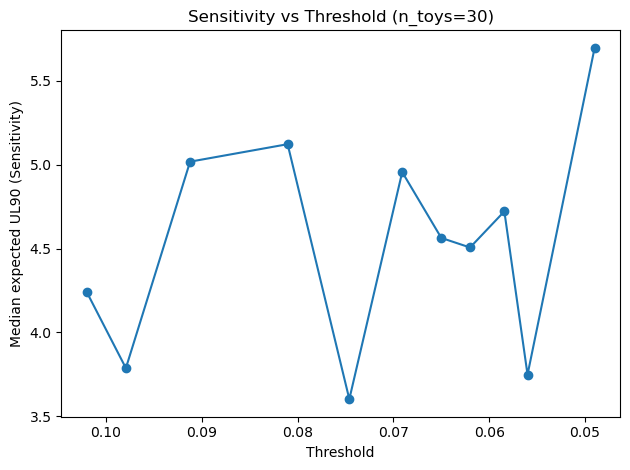

In [31]:
df_ok8 = df_step8_merged[np.isfinite(df_step8_merged["Sensitivity_median_UL"])]

plt.figure()
plt.plot(df_ok8["thr"], df_ok8["Sensitivity_median_UL"], marker="o")
plt.gca().invert_xaxis()
plt.xlabel("Threshold")
plt.ylabel("Median expected UL90 (Sensitivity)")
plt.title(f"Sensitivity vs Threshold (n_toys={N_TOYS_QUICK})")
plt.tight_layout()
plt.show()


Best thr (quick) = 0.07460000000000001


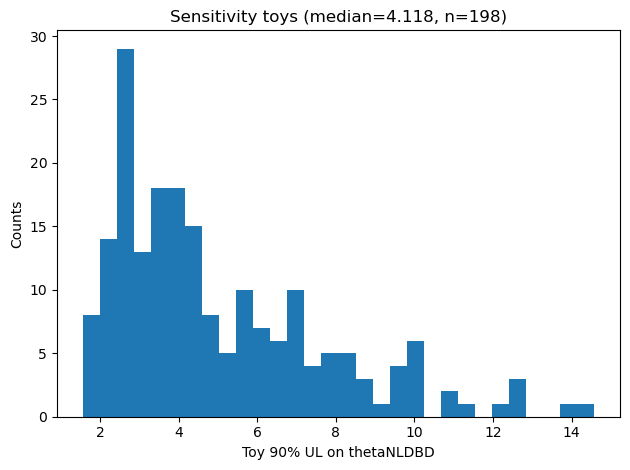

Final sensitivity (median expected UL) = 4.117708627219036


In [32]:
best_thr = float(df_ok8.loc[df_ok8["Sensitivity_median_UL"].idxmin(), "thr"])
print("Best thr (quick) =", best_thr)

y, pA, pB, pC = build_templates_for_thr(A, B, C, T, best_thr, edges)
sens_final, ULs = sensitivity_for_templates(
    y, pA, pB, pC, pN,
    n_toys=200,
    seed=RNG_SEED,
    make_hist=True
)
print("Final sensitivity (median expected UL) =", sens_final)


In [33]:
# =========================
# Final report for best_thr
# =========================

# Step5 (best_thr)
y_best, pA_best, pB_best, pC_best = build_templates_for_thr(A, B, C, T, best_thr, edges)

# Step6 fit (best_thr)
fit_best = fit_target(y_best, pA_best, pB_best, pC_best, pN)

# Step7 observed UL90 (best_thr)
ul_obs_best = ul90_profile_for_templates(
    y_best, pA_best, pB_best, pC_best, pN,
    thetaA_hat=fit_best["thetaA"],
    thetaB_hat=fit_best["thetaB"],
    thetaC_hat=fit_best["thetaC"],
    thetaN_hat=fit_best["thetaN"],
    nll_min=fit_best["fun"],
    make_plot=False
)

# TPR/FPR lookup (if df_filt available)
tpr_best = fpr_best = None
if "df_filt" in globals():
    row = df_filt.loc[np.isclose(df_filt["thr"].values, best_thr)]
    if len(row):
        tpr_best = float(row.iloc[0]["TPR_A1592"])
        fpr_best = float(row.iloc[0]["FPR_B2103"])

print("===== BEST THRESHOLD SUMMARY =====")
print(f"best_thr = {best_thr:.6f}")
if tpr_best is not None:
    print(f"TPR(A@1592±{PEAK_HALF_WIDTH}) = {tpr_best:.4f}")
if fpr_best is not None:
    print(f"FPR(B@2103±{PEAK_HALF_WIDTH}) = {fpr_best:.4f}")

print("\n--- Fit (Step6) ---")
print("Fit success:", fit_best["success"])
print(f"thetaA_hat = {fit_best['thetaA']:.2f}   (calib {THETA_A_MU}±{THETA_A_SIG})")
print(f"thetaB_hat = {fit_best['thetaB']:.2f}   (calib {THETA_B_MU}±{THETA_B_SIG})")
print(f"thetaC_hat = {fit_best['thetaC']:.2f}")
print(f"thetaN_hat = {fit_best['thetaN']:.2f}")
print(f"NLL_min    = {fit_best['fun']:.3f}")
print(f"Target total counts after cut = {float(np.sum(y_best)):.1f}")

print("\n--- Observed UL (Step7) ---")
print(f"Observed 90% UL on thetaNLDBD = {ul_obs_best:.4f}")

print("\n--- Sensitivity (Step8) ---")
print(f"Sensitivity (median expected UL) = {sens_final:.4f}  (toys used: {len(ULs)})")


===== BEST THRESHOLD SUMMARY =====
best_thr = 0.074600
TPR(A@1592±3.0) = 0.8489
FPR(B@2103±3.0) = 0.2687

--- Fit (Step6) ---
Fit success: True
thetaA_hat = 1176.48   (calib 1350.0±100.0)
thetaB_hat = 889.88   (calib 770.0±270.0)
thetaC_hat = 548.10
thetaN_hat = 11.48
NLL_min    = 721.175
Target total counts after cut = 2609.0

--- Observed UL (Step7) ---
Observed 90% UL on thetaNLDBD = 19.1915

--- Sensitivity (Step8) ---
Sensitivity (median expected UL) = 4.1177  (toys used: 198)


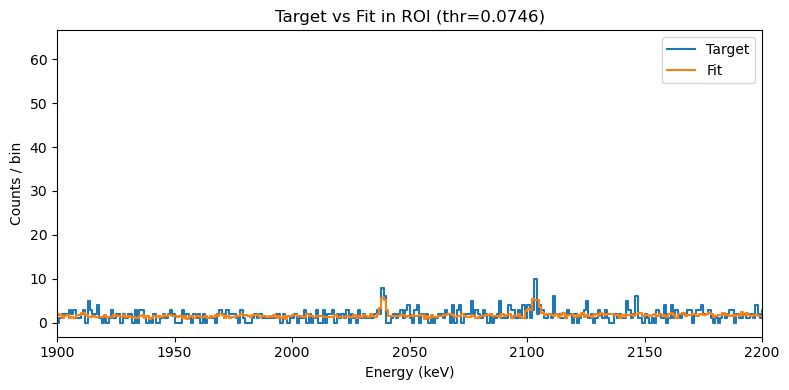

In [34]:
ROI = (1900, 2200)

plt.figure(figsize=(8,4))
plt.step(centers, y_best, where="mid", label="Target")
plt.step(centers, fit_best["mu_hat"], where="mid", label="Fit")
plt.xlim(*ROI)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts / bin")
plt.title(f"Target vs Fit in ROI (thr={best_thr:.4f})")
plt.legend()
plt.tight_layout()
plt.show()

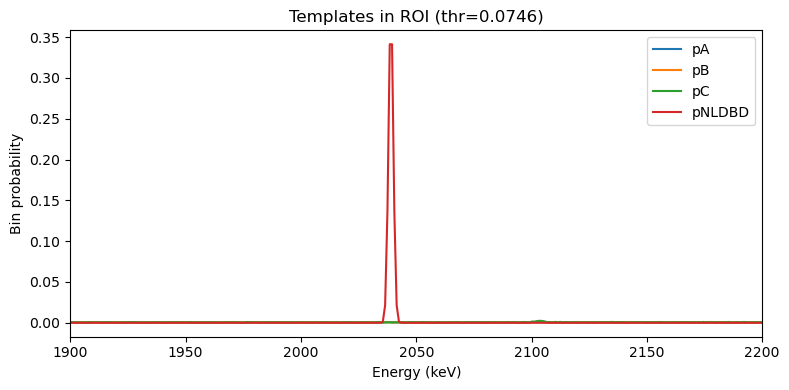

In [35]:
plt.figure(figsize=(8,4))
plt.plot(centers, pA_best, label="pA")
plt.plot(centers, pB_best, label="pB")
plt.plot(centers, pC_best, label="pC")
plt.plot(centers, pN, label="pNLDBD")
plt.xlim(*ROI)
plt.xlabel("Energy (keV)")
plt.ylabel("Bin probability")
plt.title(f"Templates in ROI (thr={best_thr:.4f})")
plt.legend()
plt.tight_layout()
plt.show()


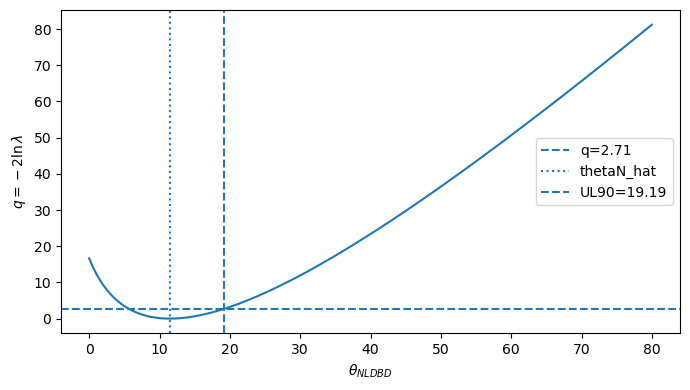

In [36]:
_ = ul90_profile_for_templates(
    y_best, pA_best, pB_best, pC_best, pN,
    thetaA_hat=fit_best["thetaA"],
    thetaB_hat=fit_best["thetaB"],
    thetaC_hat=fit_best["thetaC"],
    thetaN_hat=fit_best["thetaN"],
    nll_min=fit_best["fun"],
    make_plot=True,
    plot_xlim=(0, max(80, ul_obs_best*1.3 if np.isfinite(ul_obs_best) else 80)),
    n_grid=160
)


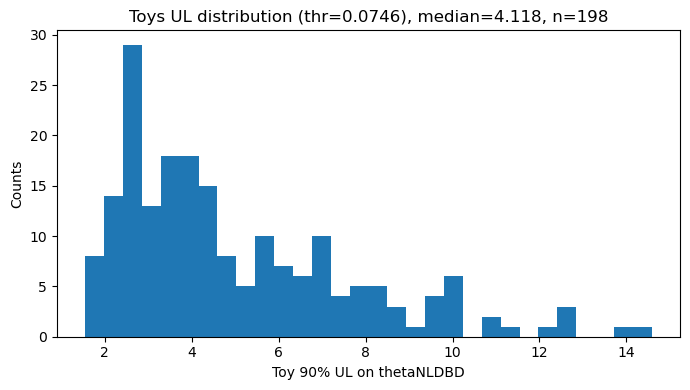

In [37]:
plt.figure(figsize=(7,4))
plt.hist(ULs, bins=30)
plt.xlabel("Toy 90% UL on thetaNLDBD")
plt.ylabel("Counts")
plt.title(f"Toys UL distribution (thr={best_thr:.4f}), median={sens_final:.3f}, n={len(ULs)}")
plt.tight_layout()
plt.show()


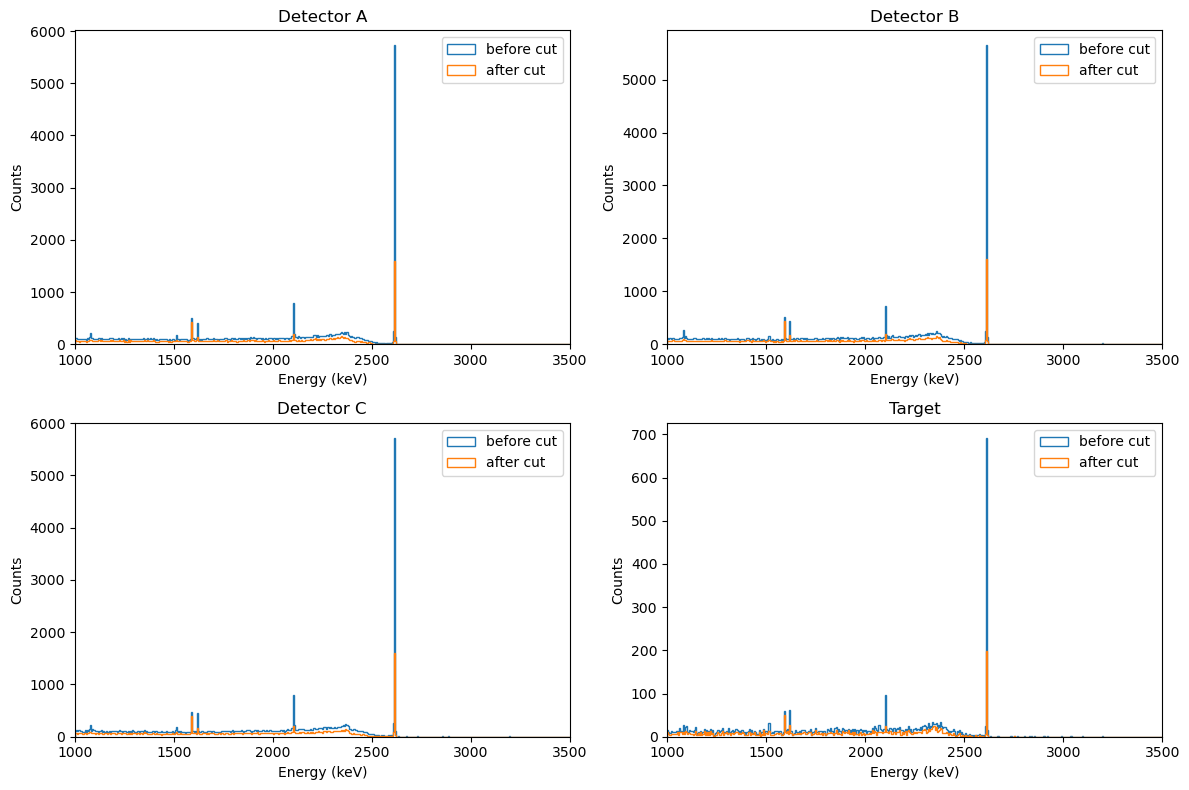

In [38]:
y_, pA_, pB_, pC_, A2, B2, C2, T2 = build_templates_for_thr(A, B, C, T, best_thr, edges, return_cut_dfs=True)

plot_before_after_grid(
    dfs_before=[A, B, C, T],
    dfs_after=[A2, B2, C2, T2],
    labels=["Detector A", "Detector B", "Detector C", "Target"],
    bins=450,
    xlim=(1000, 3500)
)
